Within this notebook we will outline all of the methods and the results.

The layout will be different to the actual document as we can discuss the methods then directly apply them and view the immediate results.

# Data

First we import the data and the required libraries. The data is in a feather format generated from a database api that connects to a MySQL database and downloads the data into a feather format after utilising an object storage method to clean the data.

In [1]:
# We import some libraries and read in the data
from carbon_converter import *
from data import *
from graph import multihist

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2
import rpy2.robjects as robjects
import rpy2.ipython.html

df = pd.read_feather('df.feather')


n*** Successfully loaded .Rprofile ***n


We set some entries to zero that are decimal numbers in integer fields.

We also limit the dataset to vineyards that are over 100m^2.

Finally we set a couple of entries for average price per tonne to nan as they recorded only $1 per tonne.

We drop a single value who has recorded water used at 4 orders of magnitude higher than those before them and is not a larger vineyard.

We also remove entries who have no GI Region.

In [2]:
df.loc[
    (df["insecticide_spraying_number_of_times_passes_per_year"]<1) & 
    (df["insecticide_spraying_number_of_times_passes_per_year"]!=0)
    , "insecticide_spraying_number_of_times_passes_per_year"] = 0

df.loc[
    (df["herbicide_spraying_number_of_times_passes_per_year"]<1) & 
    (df["herbicide_spraying_number_of_times_passes_per_year"]!=0)
    , "herbicide_spraying_number_of_times_passes_per_year"] = 0

# Too small, a fly out the window
for id in df[df['area_harvested']<1].index:
    df = df.drop(index=id)

# 1$ values for price
df.loc[1848, "average_per_tonne"] = np.nan
df.loc[5493, "average_per_tonne"] = np.nan

# Ridiculous water use
#df = df.drop(5112)

# no giregion
df = df.drop(df[df["giregion"] == "0"].index)

print()


We remove two outliers. These are interesting outliers as they are examples of what not to do. At first glance they appear to be seemingly normal vineyards, but become outliers due to their size. As one of them is a smaller vineyard they have used an excessive amount of fuel, likely because of inefficiently doing trips around the vineyards for single purposes. This behaviour does not scale up what so ever.

In [3]:
#df = df.drop(5642)
#df = df.drop(4642)

The data requires a bit of amalgamation for certain fields, specifically we calculate the total fertiliser/nitrogen, water, and fuel used. This is a simple summation.

We also calculate the total emissions of a vineyard using scope 1 and scope 2 emissions for the different fuels and electricity used. This was done using the Australian National Greenhouse Accounts Factors

In [4]:
# TODO
# add nitrogen/fertiliser added together in data pipeline
df['nitrogen_applied'] = df['synthetic_nitrogen_applied']+df['organic_nitrogen_applied']
df['fertiliser_applied'] = df['synthetic_fertiliser_applied']+df['organic_fertiliser_applied']

df["fertiliser"] = df['fertiliser_applied'] + df['nitrogen_applied']

# We convert the use of fuels into CO2E
# This includes both scope1 and scope 2 in the totals, as well as separate columns for comparison.
df["total_irrigation_electricity"] = df["total_irrigation_electricity"].apply(scope2)
df["irrigation_energy_diesel"] = df["irrigation_energy_diesel"].div(1000).apply(diesel_irrigation)
df["irrigation_energy_electricity"] = df["irrigation_energy_electricity"].div(1000).apply(scope2)
df["irrigation_energy_pressure"] = df["irrigation_energy_pressure"].div(1000).apply(scope2)
df["diesel_vineyard"] = df["diesel_vineyard"].div(1000).apply(diesel_vehicle)
df["electricity_vineyard"] = df["electricity_vineyard"].div(1000).apply(scope2)
df["petrol_vineyard"] = df["petrol_vineyard"].div(1000).apply(petrol_vehicle)
df["lpg_vineyard"] = df["lpg_vineyard"].div(1000).apply(lpg_vehicle)
df["biodiesel_vineyard"] = df["biodiesel_vineyard"].div(1000).apply(biodiesel_vehicle)

df["scope2"] = df["total_irrigation_electricity"]\
    + df["irrigation_energy_electricity"]\
    + df["irrigation_energy_pressure"]\
    + df["electricity_vineyard"]

df["scope1"] = df["irrigation_energy_diesel"]\
    + df["diesel_vineyard"]\
    + df["petrol_vineyard"]\
    + df["lpg_vineyard"]\
    + df["biodiesel_vineyard"]

df["total_emissions"] = df["scope1"] + df["scope2"]


The data set is limitted to samples who have recorded area, eidl, water used, and emissions.

In [5]:
# we limit it to recordings for the baseline variables.

df = df.replace({0: np.nan})
df = df[(df["area_harvested"].notnull()) & (df["tonnes_grapes_harvested"].notnull()) & (df["water_used"].notnull()) & (df["total_vineyard_fuel"].notnull())]
#df = df[(df["area_harvested"].notnull()) & (df["tonnes_grapes_harvested"].notnull()) & (df["water_used"].notnull()) & (df["total_emissions"].notnull())]



In [6]:
# We make some lists for ease of use

cont_var = [
    "water_used"
    , "tonnes_grapes_harvested"
    , "total_vineyard_fuel"
    , "total_vineyard_electricity"
    , "fertiliser"
]

feature_list = [
    "area_harvested"
    , "tonnes_grapes_harvested"
    , "water_used"
    , "total_tractor_passes"
    , "fertiliser"
    , "total_emissions"
]

We have a look at the sparsity of particular variables. The list below shows the percentage of each variables response rates.

In [7]:
total = len(df)
print("n = {}".format(total))
print("Proportion of entries in each column:\n")
for feature in feature_list:
    entries = len(df[df[feature].notnull()][feature])
    print("{}: {} | {}%".format(feature, entries, round((entries/total)*100, 2)))

n = 5375
Proportion of entries in each column:

area_harvested: 5375 | 100.0%
tonnes_grapes_harvested: 5375 | 100.0%
water_used: 5375 | 100.0%
total_tractor_passes: 1971 | 36.67%
fertiliser: 709 | 13.19%
total_emissions: 5375 | 100.0%


In [8]:
len(df["giregion"].unique())

57

In [9]:
len(df["member_id"].unique())

1287

In [10]:
len(df[df["average_per_tonne"].notnull()])

891

In [11]:
len(df.loc[df["average_per_tonne"].notnull(), "giregion"].unique())

45

In [12]:
len(df.loc[df["average_per_tonne"].notnull(), "member_id"].unique())

475

In [13]:
df.loc[df["average_per_tonne"].notnull(), "data_year_id"].unique()

array(['2020/2021', '2021/2022', '2019/2020', '2018/2019'], dtype=object)

### We look at the proportion of entries for each region:

In [8]:
total = len(df)
print("n = {}".format(total))
print("number of regions is {}".format(len(df["giregion"].unique())))
print("Proportion of entries in each column:\n")
for region in df["giregion"].unique():
    entries = len(df[df["giregion"]==region]["giregion"])
    print("{}: {} | {}%".format(region, entries, round((entries/total)*100, 2)))

n = 5375
number of regions is 57
Proportion of entries in each column:

Barossa Valley: 515 | 9.58%
Padthaway: 179 | 3.33%
Hunter Valley: 53 | 0.99%
Coonawarra: 267 | 4.97%
Rutherglen: 29 | 0.54%
Langhorne Creek: 319 | 5.93%
Clare Valley: 126 | 2.34%
Riverland: 445 | 8.28%
Murray Darling: 495 | 9.21%
Upper Goulburn: 20 | 0.37%
Swan Hill: 82 | 1.53%
Adelaide Hills: 407 | 7.57%
Bendigo: 52 | 0.97%
Grampians: 70 | 1.3%
Henty: 20 | 0.37%
Mount Benson: 17 | 0.32%
Wrattonbully: 160 | 2.98%
Robe: 36 | 0.67%
Currency Creek: 20 | 0.37%
Southern Fleurieu: 29 | 0.54%
McLaren Vale: 1025 | 19.07%
Yarra Valley: 108 | 2.01%
Margaret River: 302 | 5.62%
Blackwood Valley: 8 | 0.15%
Glenrowan: 4 | 0.07%
Riverina: 16 | 0.3%
Eden Valley: 88 | 1.64%
Other: 18 | 0.33%
Big Rivers Zone Other: 9 | 0.17%
Heathcote: 28 | 0.52%
Orange: 49 | 0.91%
Kangaroo Island: 10 | 0.19%
Cowra: 6 | 0.11%
Mornington Peninsula: 28 | 0.52%
Adelaide Plains: 25 | 0.47%
Mount Gambier: 9 | 0.17%
Southern Flinders Ranges: 19 | 0.35%
Ta

In [15]:
df.groupby("giregion")["member_id"].count().describe()

count      57.000000
mean       94.298246
std       179.986206
min         1.000000
25%         9.000000
50%        20.000000
75%        82.000000
max      1025.000000
Name: member_id, dtype: float64

In [16]:
region_selection = df.groupby("giregion").count()[(df.groupby("giregion").count()>50)["member_id"]].index.values
region_selection = list(region_selection).append("other")

### How do the variables correlate to each other

In [17]:
df[feature_list].corr().style.background_gradient(cmap='coolwarm')

field,area_harvested,tonnes_grapes_harvested,water_used,total_tractor_passes,fertiliser,total_emissions
field,,,,,,
area_harvested,1.000000,0.745132,-0.005221,0.074670,0.596762,0.893547
tonnes_grapes_harvested,0.745132,1.000000,-0.004234,0.087442,0.720676,0.729423
water_used,-0.005221,-0.004234,1.000000,0.041876,0.041440,-0.001848
total_tractor_passes,0.074670,0.087442,0.041876,1.000000,0.012885,0.115181
fertiliser,0.596762,0.720676,0.041440,0.012885,1.000000,0.639074
total_emissions,0.893547,0.729423,-0.001848,0.115181,0.639074,1.000000


In [18]:
dft = (1+df[feature_list]).div(1+df["area_harvested"], axis=0)
dft["total_tractor_passes"] = df["total_tractor_passes"].copy()
dft.corr().style.background_gradient(cmap='coolwarm')

/home/bryce/repositories/paper_one/venv/lib/python3.10/site-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/bryce/repositories/paper_one/venv/lib/python3.10/site-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


field,area_harvested,tonnes_grapes_harvested,water_used,total_tractor_passes,fertiliser,total_emissions
field,,,,,,
area_harvested,nan,nan,nan,nan,nan,nan
tonnes_grapes_harvested,nan,1.000000,-0.005440,0.181897,0.057453,0.098959
water_used,nan,-0.005440,1.000000,0.017428,-0.014808,0.027873
total_tractor_passes,nan,0.181897,0.017428,1.000000,-0.053964,0.194917
fertiliser,nan,0.057453,-0.014808,-0.053964,1.000000,0.074430
total_emissions,nan,0.098959,0.027873,0.194917,0.074430,1.000000


In [19]:
dft = (1+df[feature_list]).apply(np.log).div((1+df["area_harvested"].apply(np.log)), axis=0)
dft["total_tractor_passes"] = df["total_tractor_passes"].copy()
dft.corr().style.background_gradient(cmap='coolwarm')

field,area_harvested,tonnes_grapes_harvested,water_used,total_tractor_passes,fertiliser,total_emissions
field,,,,,,
area_harvested,1.000000,-0.334854,0.129180,0.156570,-0.507582,-0.794692
tonnes_grapes_harvested,-0.334854,1.000000,0.404686,0.092776,0.330749,0.384393
water_used,0.129180,0.404686,1.000000,0.045968,0.100247,-0.011797
total_tractor_passes,0.156570,0.092776,0.045968,1.000000,-0.138989,-0.002733
fertiliser,-0.507582,0.330749,0.100247,-0.138989,1.000000,0.468482
total_emissions,-0.794692,0.384393,-0.011797,-0.002733,0.468482,1.000000


### How are the varaible distributed

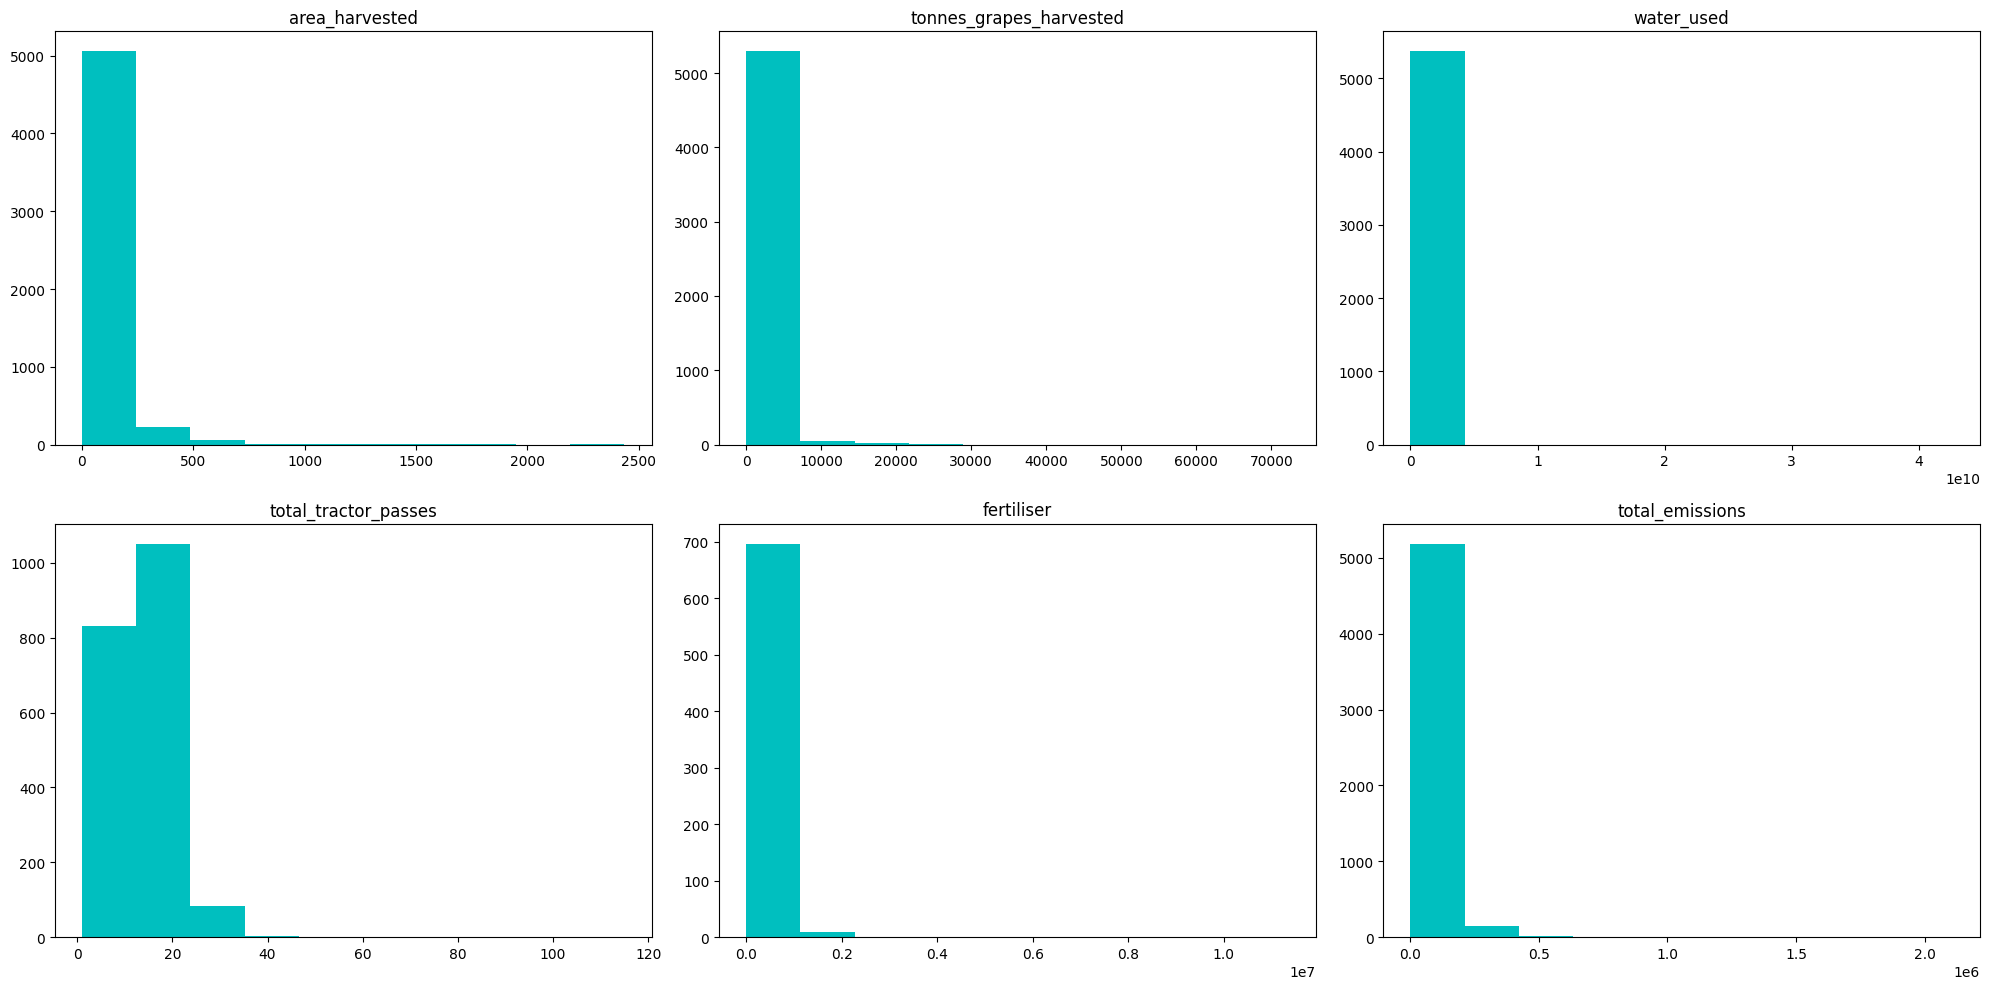

In [20]:
multihist(df[feature_list])
plt.tight_layout()

There are notably two problems with this data. It is skewed due to there being more smalelr wineries than larger, and that there are a few outliers that are likely due to user error. We remove the top and bottom ends and this fixes it.

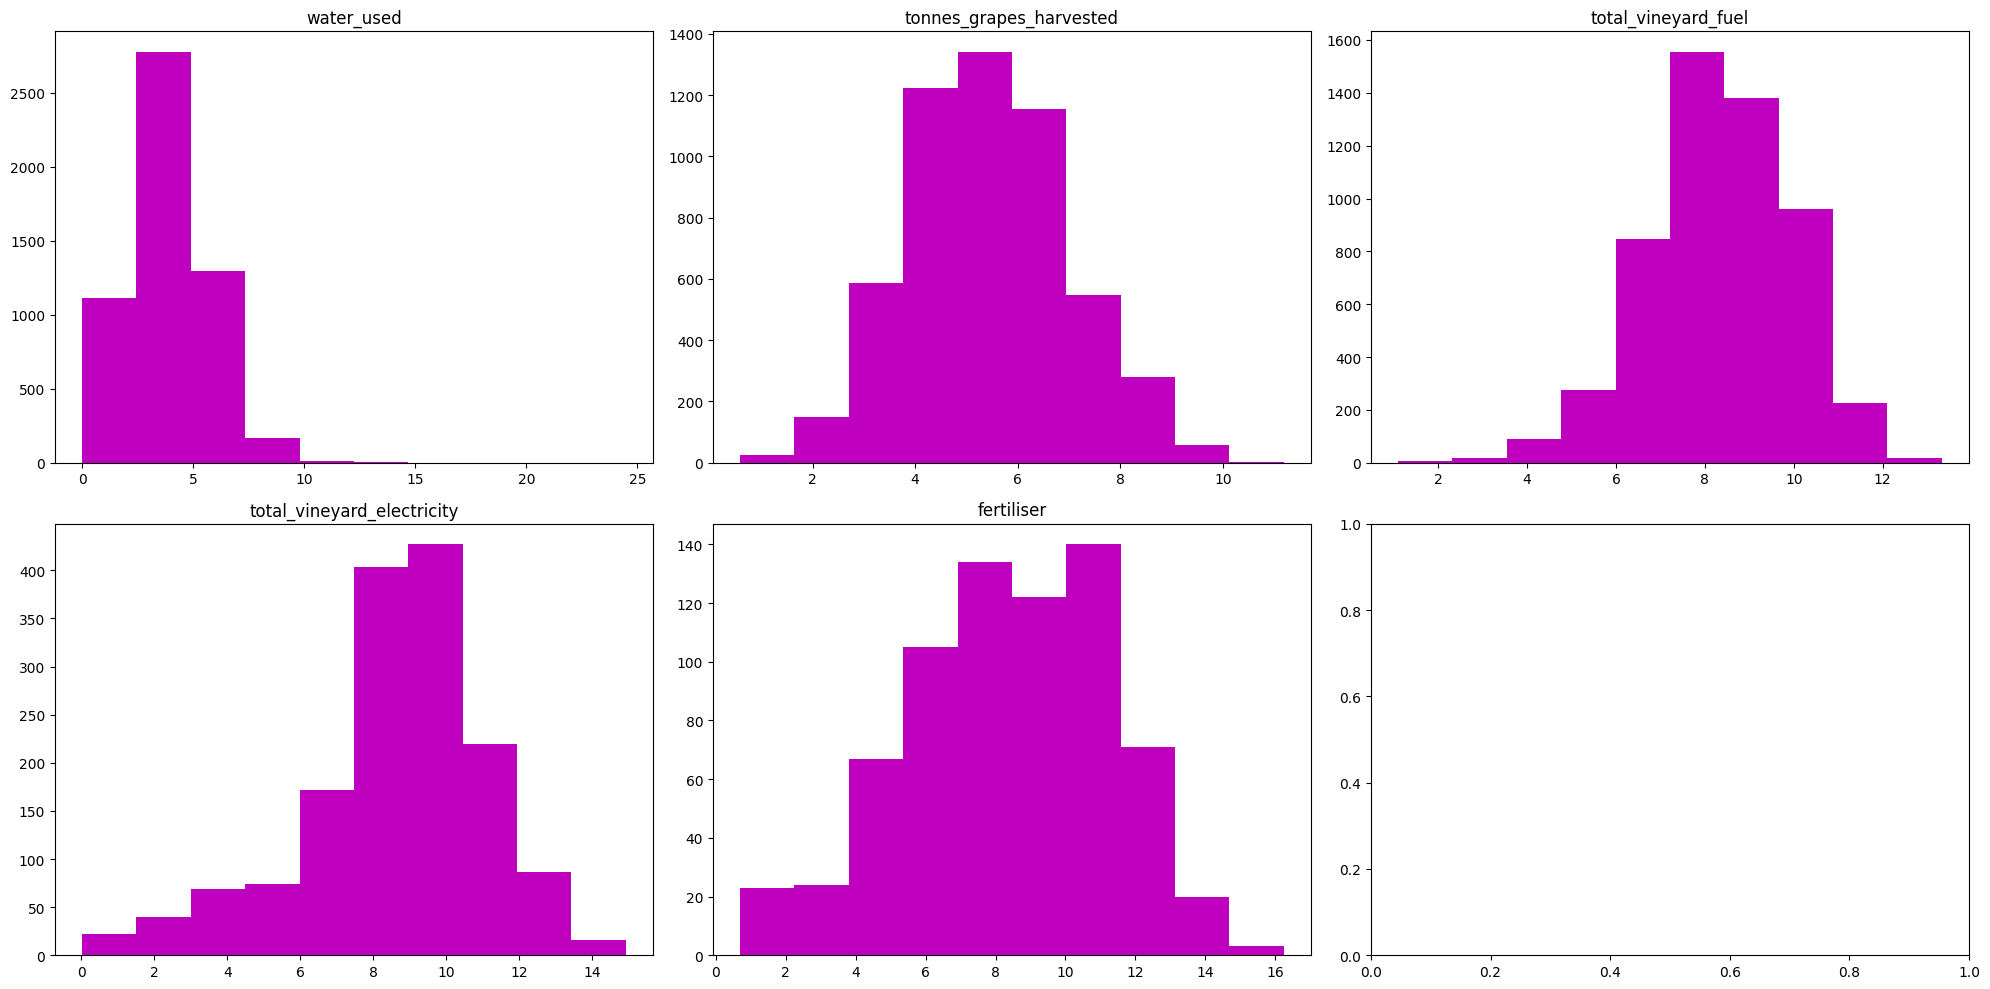

In [21]:
#If values graphed below are overwhelming large then a random error has occurred. Rerun the cell until the dissapear.
fig, ax = multihist((1+df[cont_var]).apply(np.log), color="m")
plt.tight_layout()

### GLM Baseline

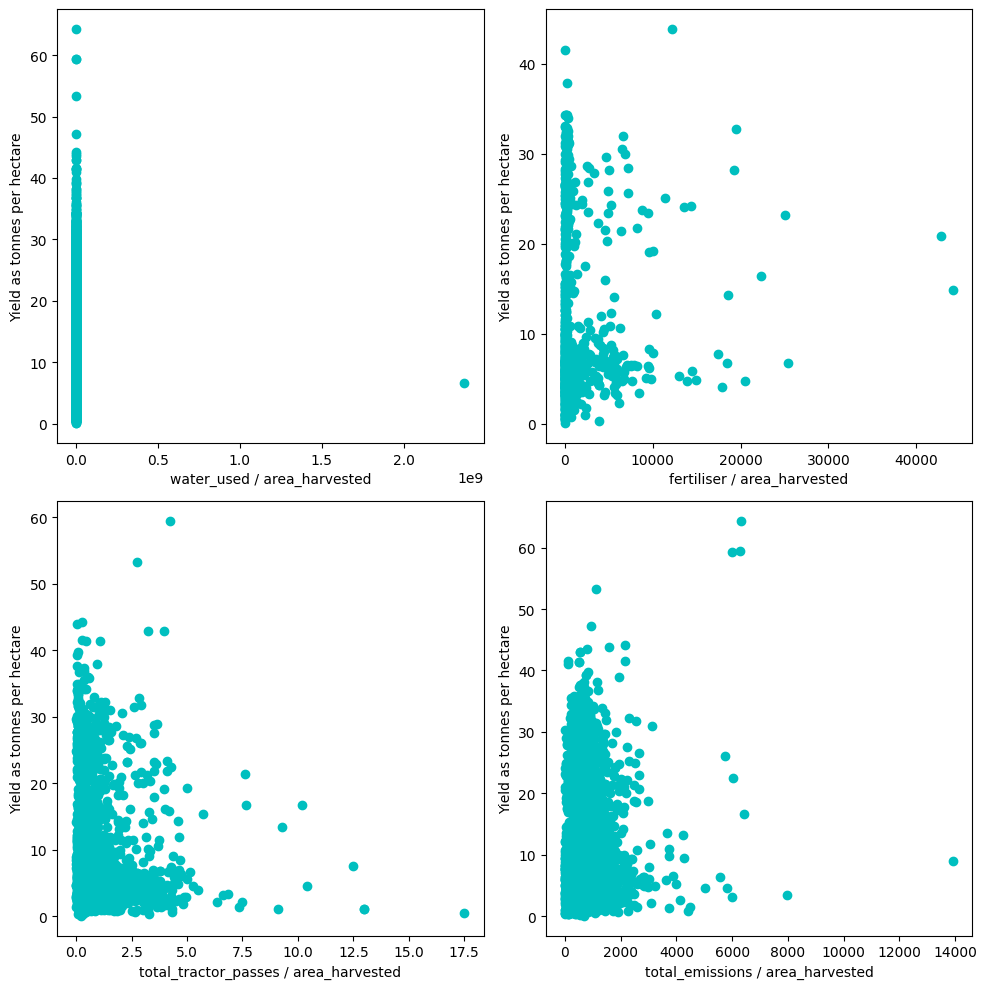

In [9]:
rows = int(round((len(feature_list))/2))-1
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(10, 10))

i = 0
j = 0
for feature in feature_list:
    if feature == 'tonnes_grapes_harvested':
        continue
    if feature == 'area_harvested':
        continue
    ax[i][j].scatter((1+df[feature]).div(1 + df["area_harvested"]),
                  df['tonnes_grapes_harvested'].div(1+df["area_harvested"]), color="c")
    ax[i][j].set_xlabel("{} / area_harvested".format(feature))
    ax[i][j].set_ylabel("Yield as tonnes per hectare")
    i += 1
    if i == rows:
        j+=1
        i=0

#fig.text(-0.01, 0.5, "Yield as tonnes per hectare", va="center", rotation='vertical')
fig.tight_layout()
plt.show()

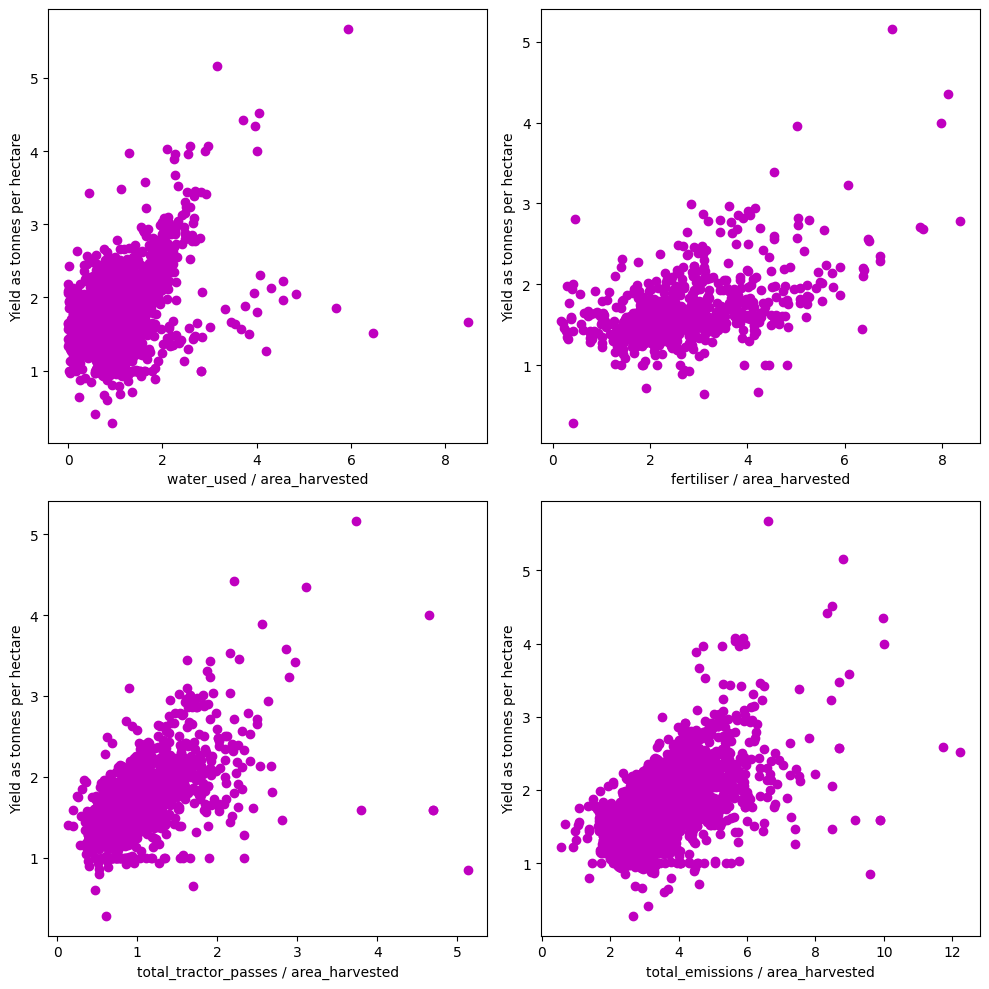

In [10]:
rows = int(round((len(feature_list))/2))-1
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(10, 10))

i = 0
j=0
for feature in feature_list:
    if feature == 'tonnes_grapes_harvested':
        continue
    if feature == 'area_harvested':
        continue 
    ax[i][j].scatter(((1+df[feature]).apply(np.log)).div((1+df["area_harvested"]).apply(np.log))
                  , (1+df['tonnes_grapes_harvested']).apply(np.log).div((1+df["area_harvested"]).apply(np.log))
                  , color="m")
    ax[i][j].set_xlabel("{} / area_harvested".format(feature))
    ax[i][j].set_ylabel("Yield as tonnes per hectare")
    i += 1
    if i == rows:
        j+=1
        i=0
        
#fig.text(0.04, 0.5, "Yield", ha="center", rotation='vertical')
fig.tight_layout()
plt.show()

In [24]:
# Model 2

rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
model = r.linear_model("data.csv", "(1+df$tonnes_grapes_harvested)/(df$area_harvested)"
    "~ (log(1+df$water_used)*(df$total_emissions)+(df$fertiliser))/(df$area_harvested)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (1 + df$tonnes_grapes_harvested)/(df$area_harvested)

Terms added sequentially (first to last)


                                                                          Df
NULL                                                                        
log(1 + df$water_used)                                                     1
df$total_emissions                                                         1
df$fertiliser                                                              1
log(1 + df$water_used):df$total_emissions                                  1
log(1 + df$water_used):df$total_emissions:df$fertiliser:df$area_harvested  1
                                                                          Deviance
NULL                                                                              
log(1 + df$water_used)                                                       59968
df$total_e

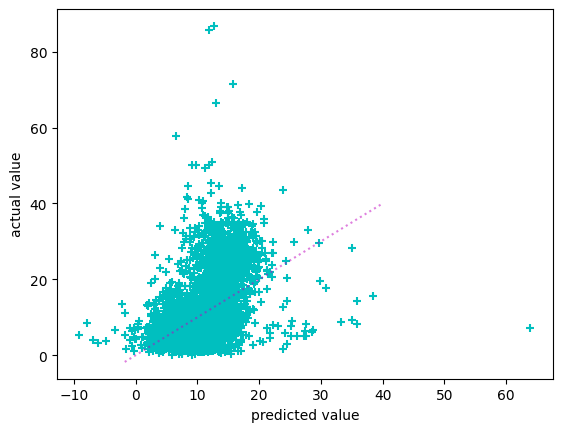

In [25]:
fig, ax = plt.subplots()

plt.plot([-1.75,40], [-1.75,40], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c"
           ,marker='+')

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show()    

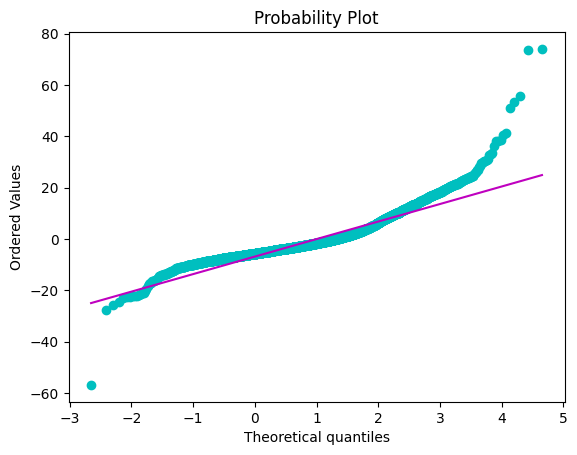

In [26]:
from scipy import stats

fig, ax = plt.subplots()

stats.probplot(
    model[1]
    , dist='norm'
    , sparams=(1)
    , plot=ax
)
ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

In [132]:
# MODEL 1

rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
model = r.linear_model("data.csv", "(df$tonnes_grapes_harvested)/(df$area_harvested)"
    "~ ((df$total_emissions)"
    "+ (df$water_used)"
    "+ (df$fertiliser))/(1+df$area_harvested)"
    "+ (df$total_tractor_passes)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (df$tonnes_grapes_harvested)/(df$area_harvested)

Terms added sequentially (first to last)


                                                                 Df Deviance
NULL                                                                        
df$total_emissions                                                1   3450.0
df$water_used                                                     1     10.1
df$fertiliser                                                     1    643.7
df$total_tractor_passes                                           1    203.2
df$total_emissions:df$water_used:df$fertiliser:df$area_harvested  1   1107.1
                                                                 Resid. Df
NULL                                                                  5374
df$total_emissions                                                    5373
df$water_used                         

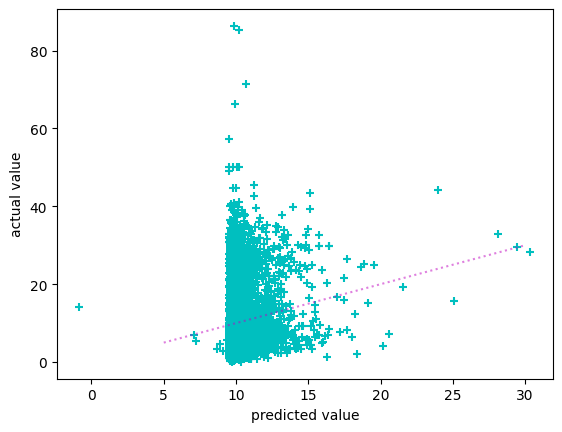

In [131]:
fig, ax = plt.subplots()

plt.plot([5,30], [5,30], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c"
           ,marker='+')

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show()    

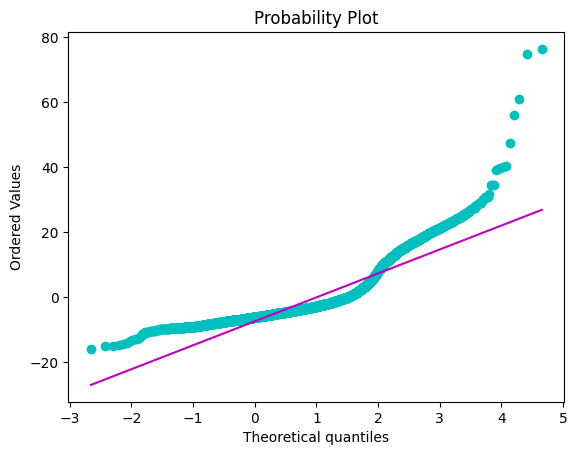

In [29]:
from scipy import stats

fig, ax = plt.subplots()

stats.probplot(
    model[1]
    , dist='norm'
    , sparams=(1)
    , plot=ax
)
ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

In [30]:
#model3

rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
model = r.linear_model("data.csv", "log(df$tonnes_grapes_harvested+1)/log(df$area_harvested+1)"
    "~ (log(df$total_emissions+1)"
    "+ log(df$water_used+1)"
    "+ log(df$fertiliser+1))/log(df$area_harvested+1)"
    "+ (1+df$total_tractor_passes)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(df$tonnes_grapes_harvested + 1)/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                                                                     Df
NULL                                                                                                   
log(df$total_emissions + 1)                                                                           1
log(df$water_used + 1)                                                                                1
log(df$fertiliser + 1)                                                                                1
df$total_tractor_passes                                                                               1
log(df$total_emissions + 1):log(df$water_used + 1):log(df$fertiliser + 1):log(df$area_harvested + 1)  1
                                                            

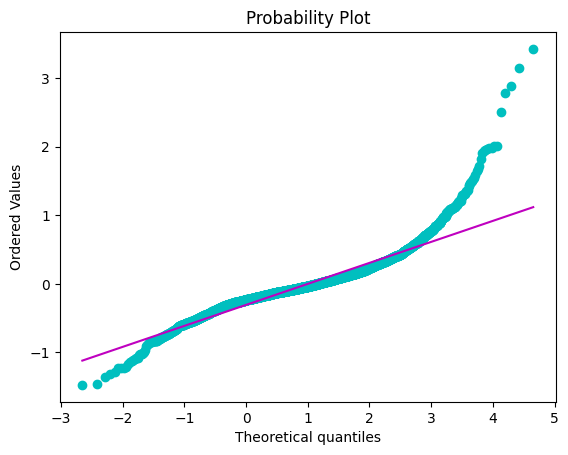

In [31]:
from scipy import stats

fig, ax = plt.subplots()

stats.probplot(
    model[1]
    , dist='norm'
    , sparams=(1)
    , plot=ax
)
ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

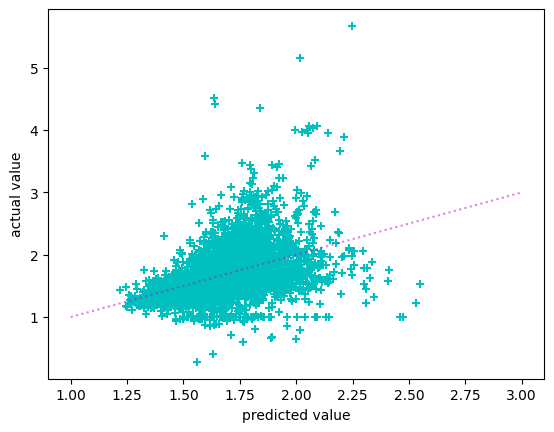

In [32]:
fig, ax = plt.subplots()

plt.plot([1,3], [1,3], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c"
           ,marker='+')

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show()    

In [33]:
#model 4

rpy2.ipython.html.init_printing()
r = robjects.r

df.to_csv("data.csv")

r.source("linear_model.r")
model = r.linear_model("data.csv", "log(df$tonnes_grapes_harvested)/log(df$area_harvested+1)"
    "~ log(1+df$total_emissions)/log(df$area_harvested+1) "
    "+ log(1+df$water_used)/log(df$area_harvested+1)"
                       #"+(1 + df$total_tractor_passes)"
                       #"+ (df$fertiliser)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(df$tonnes_grapes_harvested)/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    5374
log(1 + df$total_emissions)                             1  121.046      5373
log(1 + df$water_used)                                  1    6.252      5372
log(1 + df$total_emissions):log(df$area_harvested + 1)  1  112.976      5371
log(df$area_harvested + 1):log(1 + df$water_used)       1   12.571      5370
                                                       Resid. Dev
NULL                                                       720.65
log(1 + df$total_emissions)                                599.60
log(1 + df$water_used)                                     593.35
log(1 + df$total_emissions):log(df$area_harvested + 1)     480.38


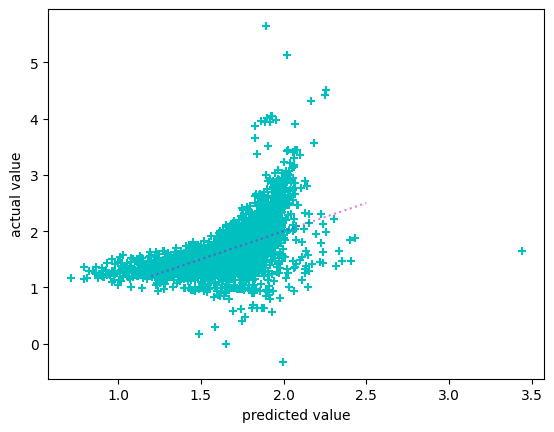

In [34]:
fig, ax = plt.subplots()

plt.plot([1.2,2.5], [1.2,2.5], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c"
           ,marker='+')

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show()    

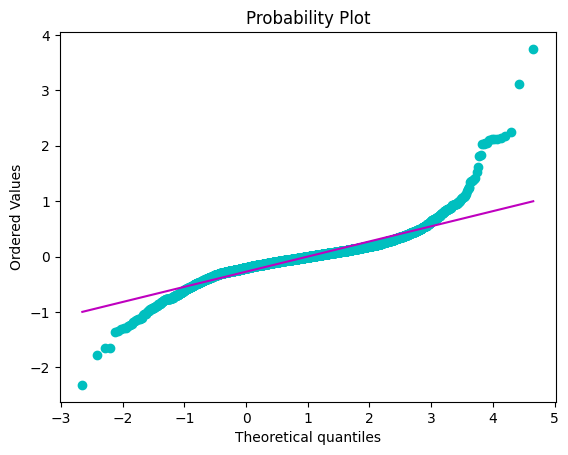

In [35]:
from scipy import stats

fig, ax = plt.subplots()

stats.probplot(
    model[1]
    , dist='norm'
    , sparams=(1)
    , plot=ax
)
ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

In [36]:
df["water_and_emmissions"] = (1+df["water_used"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)) +\
            ((1+df["total_emissions"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)))
df["yield"] = (1+df['tonnes_grapes_harvested']).apply(np.log).div((1+df["area_harvested"]).apply(np.log))



#dfr["water_and_emmissions"] = (1+dfr["water_used"]).apply(np.log).div((1+dfr["area_harvested"]).apply(np.log)) +\
#            ((1+dfr["total_emissions"]).apply(np.log).div((1+dfr["area_harvested"]).apply(np.log)))
#dfr["yield"] = (1+dfr['tonnes_grapes_harvested']).apply(np.log).div((1+dfr["area_harvested"]).apply(np.log))


df["water_and_emmissions"] = (1+df["water_used"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)) +\
            ((1+df["total_emissions"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log))
            +df["total_tractor_passes"]
             +df["fertiliser"]
            )


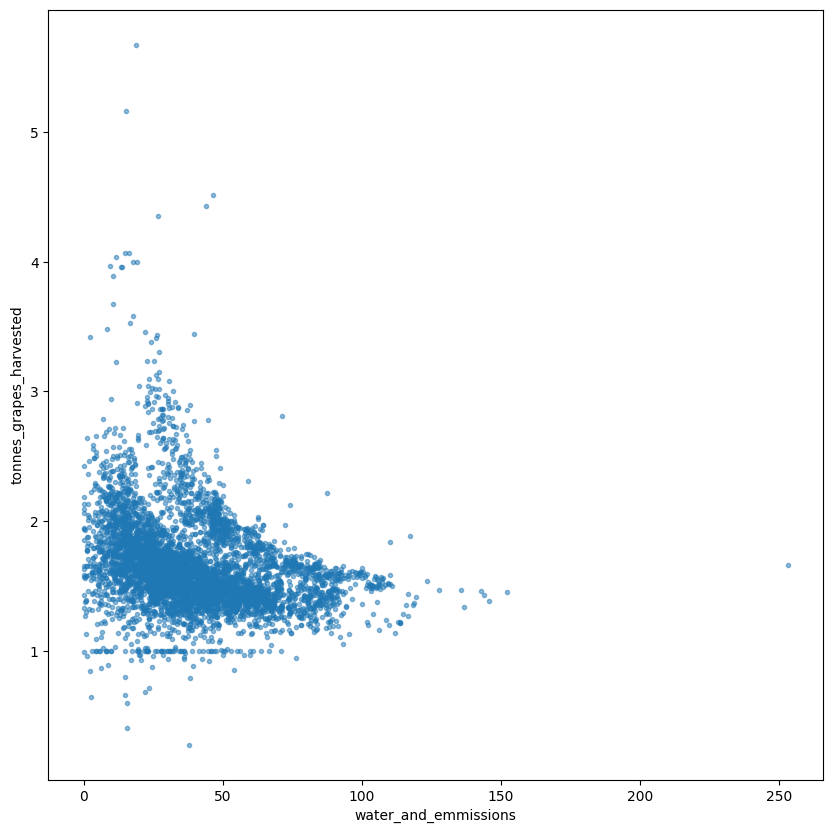

In [37]:
# This is of interest

fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    (1+df["water_used"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)) *\
            ((1+df["total_emissions"]).apply(np.log)*((1+df["area_harvested"]).apply(np.log)))
    , df["yield"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel("water_and_emmissions")
ax.set_ylabel('tonnes_grapes_harvested')

plt.show()

In [38]:
df["water_and_emmissions"] = (1+df["water_used"]).apply(np.log).div(1+df["area_harvested"].apply(np.log)) +\
    (1+df["total_emissions"]).apply(np.log).div(1+df["area_harvested"].apply(np.log))
df["yield_avg"] = (1+(df['average_per_tonne']*df['tonnes_grapes_harvested'])).apply(np.log).div((1+df["area_harvested"]).apply(np.log))
df["yield"] = ((1+df["tonnes_grapes_harvested"])).apply(np.log).div(1+df["area_harvested"].apply(np.log))
#df["water_and_emmissions"] = (1+df["water_used"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)) +\
#    ((1+df["total_emissions"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)))

#df["water_and_emmissions"] = ((1+df["total_emissions"]).div(df["area_harvested"]) + (1+df["water_used"]).div(df["area_harvested"])).apply(np.log)


In [39]:
region_selection = df.groupby("giregion").count()[(df.groupby("giregion").count()>50)["member_id"]].index.values

import matplotlib.cm as cm

region_color = {}
color = iter(cm.rainbow(np.linspace(0, 1, len(region_selection))))

for i in range(len(region_selection)):
   region_color[region_selection[i]] = i = next(color)

df['colors'] = df[df["giregion"].isin(region_selection)]["giregion"].apply(lambda x: region_color[x])

In [40]:
import matplotlib.cm as cm

year_color = {}
color = iter(cm.rainbow(np.linspace(0, 1, len(df["data_year_id"].unique()))))

for i in range(len(df["data_year_id"].unique())):
   year_color[df["data_year_id"].unique()[i]] = i = next(color)

df['ycolors'] = df["data_year_id"].apply(lambda x: year_color[x])

### Finances

In [41]:
df.groupby("giregion")["average_per_tonne"].describe()

,count,mean,std,min,25%,50%,75%,max
giregion,,,,,,,,
Adelaide Hills,60.0,1878.683333,380.167960,1025.0,1703.75,1908.00,2089.5000,3024.00
Adelaide Plains,5.0,1227.000000,191.428838,935.0,1200.00,1200.00,1400.0000,1400.00
Alpine Valleys,2.0,1125.000000,247.487373,950.0,1037.50,1125.00,1212.5000,1300.00
Barossa Valley,95.0,2836.252632,1363.352103,757.0,2050.00,2472.00,3234.0000,9000.00
Barossa Zone,3.0,2043.333333,487.476495,1530.0,1815.00,2100.00,2300.0000,2500.00
Beechworth,1.0,2600.000000,NaN,2600.0,2600.00,2600.00,2600.0000,2600.00
Bendigo,13.0,1503.230769,417.431462,750.0,1400.00,1550.00,1682.0000,2200.00
Big Rivers Zone Other,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Blackwood Valley,2.0,1125.000000,318.198052,900.0,1012.50,1125.00,1237.5000,1350.00


In [42]:
# model 5

rpy2.ipython.html.init_printing()
r = robjects.r
#feature_list.append("average_per_tonne")

from data import mean_sale_price

avg_prices = df[
    df["average_per_tonne"].isnull()].apply(
    lambda x: mean_sale_price(x["giregion"],
                              x["data_year_id"]),
    axis=1)
df["average_per_tonne"] = df["average_per_tonne"].replace({0: np.nan})
df["average_per_tonne"] = df["average_per_tonne"].combine_first(avg_prices)

dfr = df.loc[df[df["average_per_tonne"]!=0].index, feature_list].copy()
dfr["average_per_tonne"] = df.loc[df[df["average_per_tonne"]!=0].index, "average_per_tonne"]

dfr.to_csv("data.csv")

r.source("linear_model.r")

model = r.linear_model("data.csv", "(log(df$average_per_tonne*(1+df$tonnes_grapes_harvested)))/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1) "
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (log(df$average_per_tonne * (1 + df$tonnes_grapes_harvested)))/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    2906
log(df$total_emissions + 1)                             1  3090.49      2905
log(df$water_used + 1)                                  1   213.04      2904
log(df$total_emissions + 1):log(df$area_harvested + 1)  1   324.27      2903
log(df$area_harvested + 1):log(df$water_used + 1)       1   446.54      2902
                                                       Resid. Dev
NULL                                                       5596.8
log(df$total_emissions + 1)                                2506.3
log(df$water_used + 1)                                     2293.2
log(df$total_emissions + 1):log(df$

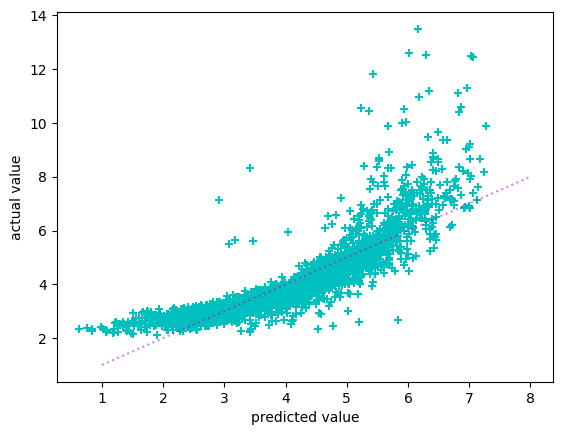

In [43]:
fig, ax = plt.subplots()

plt.plot([1,8], [1,8], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c"
           ,marker='+')

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show()    

In [44]:
print(np.corrcoef(model[2]
    , model[17]))

[[1.        0.8532175]
 [0.8532175 1.       ]]


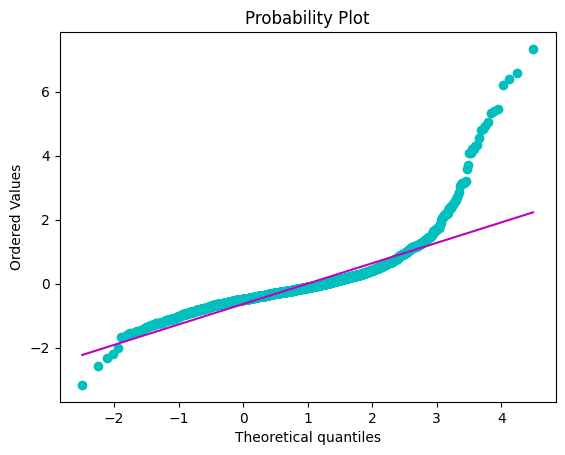

In [45]:
from scipy import stats


from scipy import stats



fig, ax = plt.subplots()

stats.probplot(
    model[1]
    , dist='norm'
    , sparams=(1)
    , plot=ax
)

ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

In [46]:
feature_list

['area_harvested',
 'tonnes_grapes_harvested',
 'water_used',
 'total_tractor_passes',
 'fertiliser',
 'total_emissions']

In [47]:
rpy2.ipython.html.init_printing()
r = robjects.r


df["average_per_tonne"] = df["average_per_tonne"].replace({0: np.nan})
df["average_per_tonne"] = df["average_per_tonne"].combine_first(avg_prices)

dfr = df.loc[df[df["average_per_tonne"].notnull()].index, ["giregion", "average_per_tonne", 'area_harvested',
 'tonnes_grapes_harvested',
 'water_used',
 'total_emissions']].copy()

region_models = {}

for region in dfr["giregion"].unique():
    if type(region) is not str:
        continue
    if len(dfr[(dfr["giregion"]==region)]) < 50:
        continue
    dfr[dfr["giregion"]==region].to_csv("data.csv")

    r.source("linear_model.r")
    model = r.linear_model("data.csv", "(log(df$average_per_tonne*(1+df$tonnes_grapes_harvested)))/log(df$area_harvested+1)"
        "~ log(df$total_emissions+1)/log(df$area_harvested+1) "
        "+ log(df$water_used+1)/log(df$area_harvested+1) "
    )

    region_models[region] = model
    
    rpy2.ipython.html.init_printing()
r = robjects.r



***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (log(df$average_per_tonne * (1 + df$tonnes_grapes_harvested)))/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                     344
log(df$total_emissions + 1)                             1   373.70       343
log(df$water_used + 1)                                  1     0.08       342
log(df$total_emissions + 1):log(df$area_harvested + 1)  1     0.67       341
log(df$area_harvested + 1):log(df$water_used + 1)       1    17.27       340
                                                       Resid. Dev
NULL                                                       506.12
log(df$total_emissions + 1)                                132.42
log(df$water_used + 1)                                     132.35
log(df$total_emissions + 1):log(df$

                                             1.0443449 
                                log(df$water_used + 1) 
                                            -1.9259088 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                            -0.3003342 
     log(df$area_harvested + 1):log(df$water_used + 1) 
                                             0.4374840 

***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (log(df$average_per_tonne * (1 + df$tonnes_grapes_harvested)))/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                     130
log(df$total_emissions + 1)                             1  206.557       129
log(df$water_used + 1)                                  1   13.227       128
log(df$total_emissions + 1):log(df$area_harvested + 1)  1    

    Min       1Q   Median       3Q      Max  
-1.7821  -0.3181  -0.1171   0.2179   3.7961  

Coefficients:
                                                       Estimate Std. Error
(Intercept)                                             5.26087    0.49832
log(df$total_emissions + 1)                             0.73873    0.08411
log(df$water_used + 1)                                 -1.19715    0.10759
log(df$total_emissions + 1):log(df$area_harvested + 1) -0.28145    0.01608
log(df$area_harvested + 1):log(df$water_used + 1)       0.41246    0.03448
                                                       t value Pr(>|t|)    
(Intercept)                                             10.557  < 2e-16 ***
log(df$total_emissions + 1)                              8.783 2.26e-16 ***
log(df$water_used + 1)                                 -11.127  < 2e-16 ***
log(df$total_emissions + 1):log(df$area_harvested + 1) -17.499  < 2e-16 ***
log(df$area_harvested + 1):log(df$water_used + 1)       11.962 

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (log(df$average_per_tonne * (1 + df$tonnes_grapes_harvested)))/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                      76
log(df$total_emissions + 1)                             1   37.770        75
log(df$water_used + 1)                                  1   21.829        74
log(df$total_emissions + 1):log(df$area_harvested + 1)  1    6.720        73
log(df$area_harvested + 1):log(df$water_used + 1)       1   14.802        72
                                                       Resid. Dev
NULL                                                       87.407
log(df$total_emissions + 1)                                49.637
log(df$water_used + 1)                                     27.808
log(df$total_emissions + 1):log(df$area_harvested + 1)     21.088
log

Residual deviance:  12.33  on 57  degrees of freedom
AIC: 87.811

Number of Fisher Scoring iterations: 2


***************
*  GLM Coefs  *

                                           (Intercept) 
                                             6.0904063 
                           log(df$total_emissions + 1) 
                                             0.5129328 
                                log(df$water_used + 1) 
                                            -1.0986419 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                            -0.1843412 
     log(df$area_harvested + 1):log(df$water_used + 1) 
                                             0.2695272 


In [48]:
for region in region_models:
    print("\n{}".format(region))
    print(region_models[region][0])


Barossa Valley
                                           (Intercept) 
                                             9.1966782 
                           log(df$total_emissions + 1) 
                                            -0.2474728 
                                log(df$water_used + 1) 
                                            -0.4593530 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                            -0.1043594 
     log(df$area_harvested + 1):log(df$water_used + 1) 
                                             0.1787852 


Coonawarra
                                           (Intercept) 
                                             5.0332286 
                           log(df$total_emissions + 1) 
                                             0.4238879 
                                log(df$water_used + 1) 
                                            -0.5875915 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                   

In [49]:
for region in region_models:
    print("\n{}".format(region))
    print(region_models[region][3])


Barossa Valley
                                           (Intercept) 
                                         -73.568508833 
                           log(df$total_emissions + 1) 
                                          19.331283241 
                                log(df$water_used + 1) 
                                           0.277704412 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                           0.816605881 
     log(df$area_harvested + 1):log(df$water_used + 1) 
                                          -4.155692285 
                                                       
                                          -0.207135207 
                                                       
                                          -0.236819344 
                                                       
                                          -0.174184054 
                                                       
                                

                                           (Intercept) 
                                          -56.03969970 
                           log(df$total_emissions + 1) 
                                           13.68354158 
                                log(df$water_used + 1) 
                                           -2.39287764 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                           -5.80117533 
     log(df$area_harvested + 1):log(df$water_used + 1) 
                                            4.72524729 
                                                       
                                           -0.58924406 
                                                       
                                           -0.71463666 
                                                       
                                           -0.36186208 
                                                       
                                           -0.43

                                           (Intercept) 
                                        -47.2863694432 
                           log(df$total_emissions + 1) 
                                          7.0381456569 
                                log(df$water_used + 1) 
                                          1.5689591717 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                          2.9373278650 
     log(df$area_harvested + 1):log(df$water_used + 1) 
                                         -1.6034171952 
                                                       
                                          0.1753933693 
                                                       
                                          0.0302823972 
                                                       
                                          0.0267708674 
                                                       
                                          0.6255

                                           (Intercept) 
                                        -32.4590984767 
                           log(df$total_emissions + 1) 
                                          8.7089527166 
                                log(df$water_used + 1) 
                                         -2.8898911479 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                          7.7528589908 
     log(df$area_harvested + 1):log(df$water_used + 1) 
                                          6.9208491587 
                                                       
                                          0.1992458105 
                                                       
                                         -0.2219909313 
                                                       
                                          0.1413580680 
                                                       
                                          0.2528

                                           (Intercept) 
                                         -71.672781625 
                           log(df$total_emissions + 1) 
                                          21.100422979 
                                log(df$water_used + 1) 
                                           7.825297328 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                           1.584159871 
     log(df$area_harvested + 1):log(df$water_used + 1) 
                                          -8.130149336 
                                                       
                                           0.326128267 
                                                       
                                           0.122109142 
                                                       
                                          -0.515349439 
                                                       
                                          -0.405

                                           (Intercept) 
                                         -48.897868867 
                           log(df$total_emissions + 1) 
                                         -14.372083045 
                                log(df$water_used + 1) 
                                          -3.636938405 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                          -0.155359864 
     log(df$area_harvested + 1):log(df$water_used + 1) 
                                           7.350392800 
                                                       
                                           0.314870274 
                                                       
                                           0.357198807 
                                                       
                                           0.418477154 
                                                       
                                          -0.505

                                           (Intercept) 
                                       -27.54630130327 
                           log(df$total_emissions + 1) 
                                         6.08979184625 
                                log(df$water_used + 1) 
                                        -2.09933895793 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                         0.61653827048 
     log(df$area_harvested + 1):log(df$water_used + 1) 
                                         2.51530530989 
                                                       
                                        -0.09560605774 
                                                       
                                        -0.04913239231 
                                                       
                                         0.07726035772 
                                                       
                                         0.00002

                                           (Intercept) 
                                        -36.6383705796 
                           log(df$total_emissions + 1) 
                                         -5.1331736118 
                                log(df$water_used + 1) 
                                          2.2395781448 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                         -2.2881535114 
     log(df$area_harvested + 1):log(df$water_used + 1) 
                                          1.8275420983 
                                                       
                                          0.1519864088 
                                                       
                                          0.3112517811 
                                                       
                                          0.3665000625 
                                                       
                                          0.2005

                                           (Intercept) 
                                         -77.590253626 
                           log(df$total_emissions + 1) 
                                          17.318299012 
                                log(df$water_used + 1) 
                                           5.785451652 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                           8.314121942 
     log(df$area_harvested + 1):log(df$water_used + 1) 
                                           6.012215577 
                                                       
                                          -0.303967710 
                                                       
                                          -1.297444655 
                                                       
                                           0.526703150 
                                                       
                                           0.597

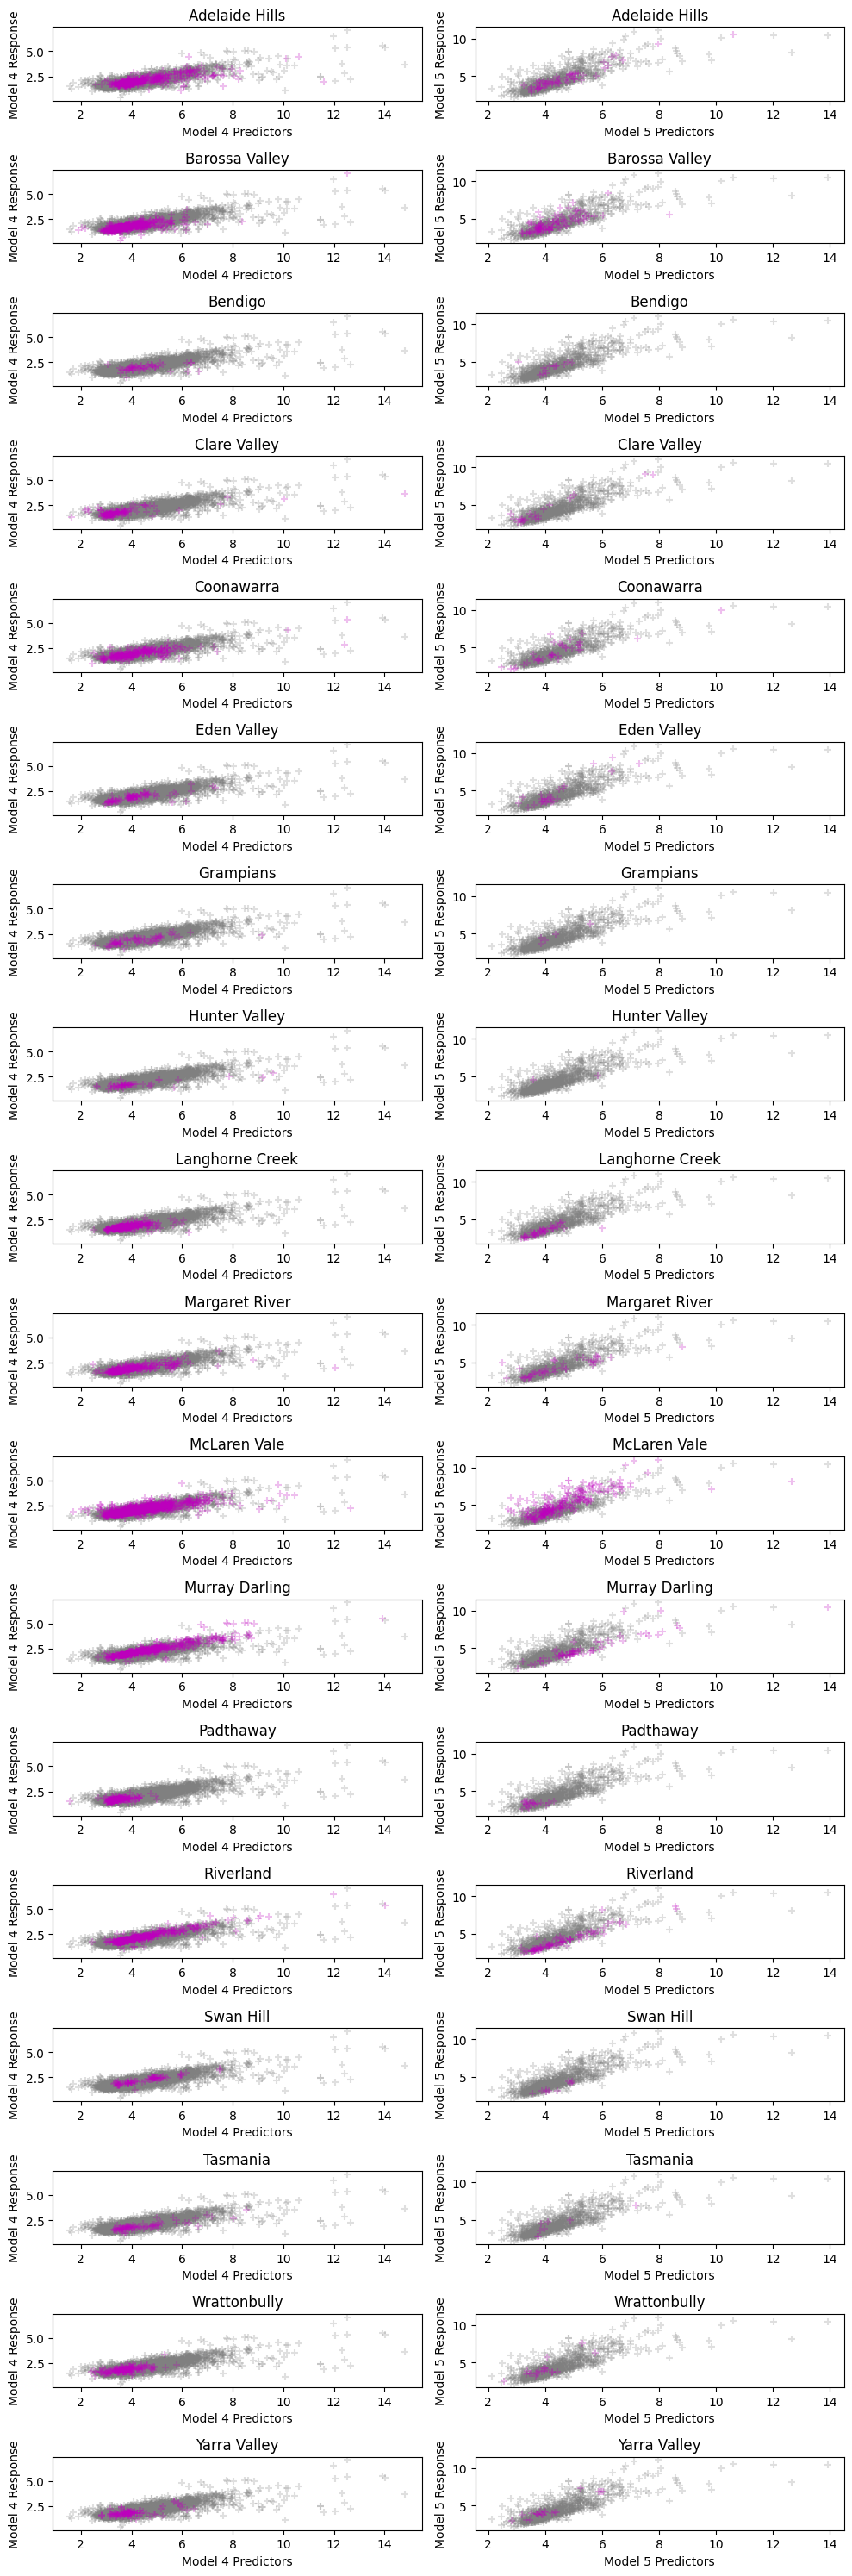

In [133]:
fig, ax = plt.subplots(len(region_selection), 2,  figsize=(10, 30))
i=0

#ax[1].set_xlabel(r'$\frac{\log(Total\/Emissions)}{log(Area\/Harvested)}+\frac{\log(Water\/Used)}{log(Area\/Harvested)}$')
#ax[1].set_ylabel(r'$\frac{\log(Tonnes\/Grapes\/Harvested)}{\log(Area\/Harvested)}$')
for region in region_selection:
    axscatter = ax[i][0].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]!=region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]!=region, "area_harvested"]).apply(np.log))
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "+"
    )
    scatter = ax[i][0].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]==region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]==region, "area_harvested"]).apply(np.log))
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "+"
    )
    ax[i][0].set_title(region)
    #ax[i][0].set_xlabel(r'$\frac{\log(Total\/Emissions)}{log(Area\/Harvested)}+\frac{\log(Water\/Used)}{log(Area\/Harvested)}$')
    ax[i][0].set_xlabel(r'Model 4 Predictors')
    #ax[i][0].set_ylabel(r'$\frac{\log(Tonnes\/Grapes\/Harvested)}{\log(Area\/Harvested)}$')
    ax[i][0].set_ylabel(r'Model 4 Response')
    ##
    axscatter = ax[i][1].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , df.loc[df["giregion"]!=region, 'yield_avg']
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "+"
    )
    scatter = ax[i][1].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , df.loc[df["giregion"]==region, 'yield_avg']
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "+"
    )
    ax[i][1].set_title(region)
    ax[i][1].set_xlabel(r'Model 5 Predictors')
    #ax[i][1].set_xlabel(r'$\frac{\log(Total\/Emissions)}{log(Area\/Harvested)}+\frac{\log(Water\/Used)}{log(Area\/Harvested)}$')
    #ax[i][1].set_ylabel(r'$\frac{\log(Average\/Price/\times\/Tonnes\/Grapes\/Harvested)}{\log(Area\/Harvested)}$', fontsize=7)
    ax[i][1].set_ylabel(r'Model 5 Response')
    i += 1

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

### Regional Climates

In [51]:
df["rain"] = df["giregion"].apply(rain)
df["temp"] = df["giregion"].apply(temp)
df.loc[df["rain"]=="Unknown Climate", "rain"] = np.nan
df.loc[df["temp"]=="Unknown Climate", "temp"] = np.nan
df["climate"] = df["temp"] + " " + df["rain"]
df.loc[df["climate"]=="Unknown Climate Unknown Climate", "climate"] = np.nan

In [52]:
palette=[
        "#009292",
        "#ff6db6",
        "#490092",
        "#b66dff",
        "#6db6ff",
        "#b6dbff",
        "#920000",
        "#db6d00",
        "#24ff24",
        "#ffff6d",
        "#006ddb",
        "#000000",
        "#004949",
        "#ffb6db",
        "#924900",
    ]

import matplotlib.cm as cm

climate_color = {}
color = iter(palette)

climate_selection = df["climate"].unique()

for i in range(len(climate_selection)):
   climate_color[climate_selection[i]] = i = next(color)

df['clim_colors'] = df.loc[df["climate"].notnull(), "climate"].apply(lambda x: climate_color[x])



In [53]:
df["climate"].unique()

array(['Warm Very Dry', 'Mild Dry', 'Hot Damp', 'Cool Dry', 'Warm Dry',
       'Hot Very Dry', 'Cool Damp', 'Mild Very Dry', 'Warm Damp', nan,
       'Mild Damp', 'Cool Very Dry'], dtype=object)

In [54]:
import matplotlib.cm as cm

rain_color = {}
color = iter(palette)

rain_selection = df.loc[df["climate"].notnull(), "rain"].unique()

for i in range(len(rain_selection)):
   rain_color[rain_selection[i]] = i = next(color)

df['rain_colors'] = df.loc[df["climate"].notnull(),"rain"].apply(lambda x: rain_color[x])

temp_selection = df.groupby("temp").count()[(df.groupby("temp").count()>50)["member_id"]].index.values

import matplotlib.cm as cm

temp_color = {}
color = iter(palette)
temp_selection = df.loc[df["climate"].notnull(), "temp"].unique()

for i in range(len(temp_selection)):
   temp_color[temp_selection[i]] = i = next(color)

df['temp_colors'] = df.loc[df["climate"].notnull(), "temp"].apply(lambda x: temp_color[x])

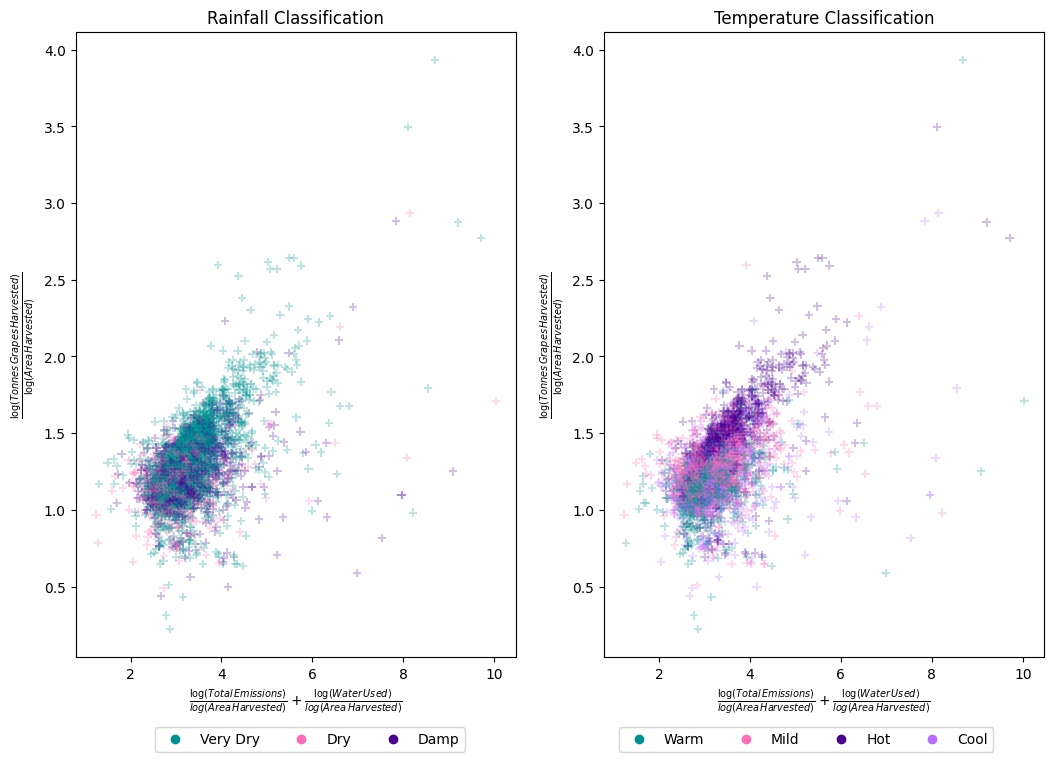

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12.5, 8.125))

scatter = ax[0].scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield'],
    c=df.loc[df["climate"].notnull(), "rain_colors"]
    , label=df.loc[df["climate"].notnull(), "rain"]
    , marker= "+"
    , alpha=0.25
)

ax[0].set(title="Rainfall Classification")

ax[0].set_xlabel(r'$\frac{\log(Total\/Emissions)}{log(Area\/Harvested)}+\frac{\log(Water\/Used)}{log(Area\/Harvested)}$')
ax[0].set_ylabel(r'$\frac{\log(Tonnes\/Grapes\/Harvested)}{\log(Area\/Harvested)}$')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in rain_color.values()]
ax[0].legend(markers, rain_selection, bbox_to_anchor=(.9, -.1), ncol=6)

scatter = ax[1].scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "+"
    , alpha=0.25
)

ax[1].set(title="Temperature Classification")

ax[1].set_xlabel(r'$\frac{\log(Total\/Emissions)}{log(Area\/Harvested)}+\frac{\log(Water\/Used)}{log(Area\/Harvested)}$')
ax[1].set_ylabel(r'$\frac{\log(Tonnes\/Grapes\/Harvested)}{\log(Area\/Harvested)}$')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
ax[1].legend(markers, temp_selection, bbox_to_anchor=(.9, -0.1), ncol=6)

plt.show()

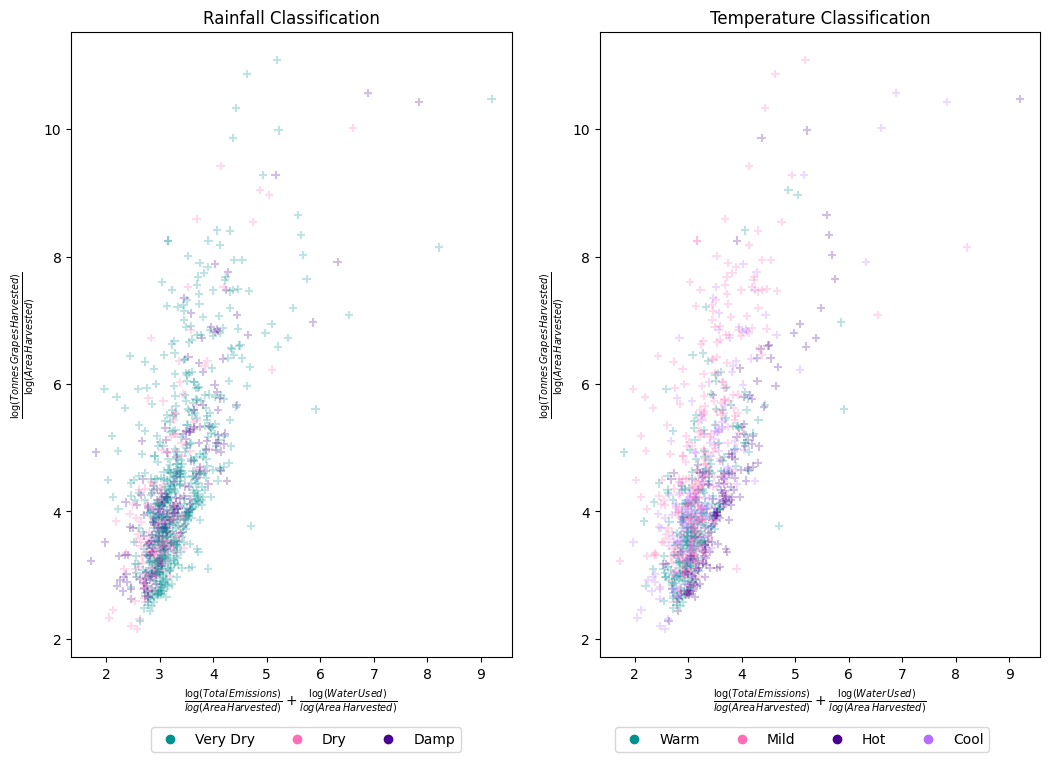

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(12.5, 8.125))

scatter = ax[0].scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "rain_colors"]
    , label=df.loc[df["climate"].notnull(), "rain"]
    , marker= "+"
    , alpha=0.25
)

ax[0].set(title="Rainfall Classification")

ax[0].set_xlabel(r'$\frac{\log(Total\/Emissions)}{log(Area\/Harvested)}+\frac{\log(Water\/Used)}{log(Area\/Harvested)}$')
ax[0].set_ylabel(r'$\frac{\log(Tonnes\/Grapes\/Harvested)}{\log(Area\/Harvested)}$')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in rain_color.values()]
ax[0].legend(markers, rain_selection, bbox_to_anchor=(.9, -.1), ncol=6)

scatter = ax[1].scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "+"
    , alpha=0.25
)

ax[1].set(title="Temperature Classification")

ax[1].set_xlabel(r'$\frac{\log(Total\/Emissions)}{log(Area\/Harvested)}+\frac{\log(Water\/Used)}{log(Area\/Harvested)}$')
ax[1].set_ylabel(r'$\frac{\log(Tonnes\/Grapes\/Harvested)}{\log(Area\/Harvested)}$')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
ax[1].legend(markers, temp_selection, bbox_to_anchor=(.9, -0.1), ncol=6)

plt.show()

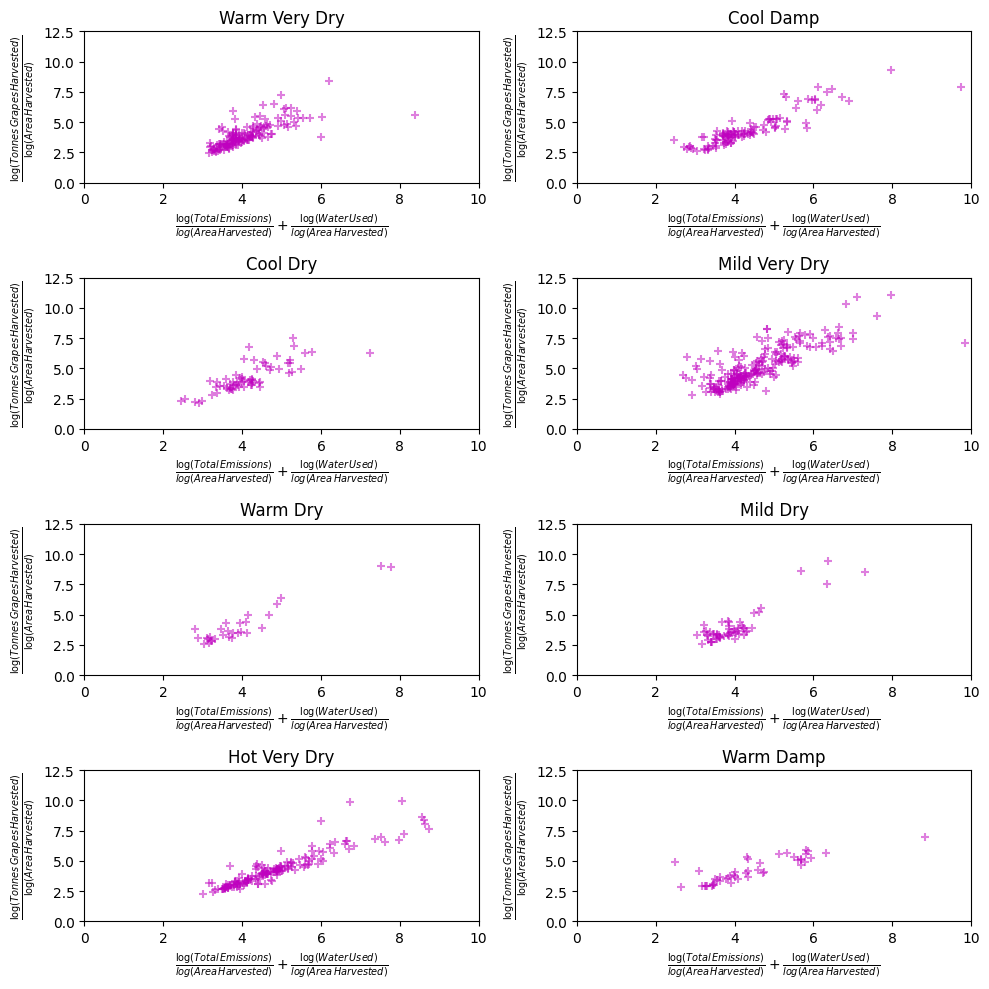

In [102]:
fig, ax = plt.subplots(4, 2,  figsize=(10, 10))

i=0
j=0

climate_list = [
    "Warm Very Dry",
    "Cool Dry",
    "Warm Dry",
    "Hot Very Dry",
    "Cool Damp",
    "Mild Very Dry",
    "Mild Dry",
    "Warm Damp"
]

for climate in climate_list:
    if type(climate) is not str:
        continue
    scatter = ax[i][j].scatter(
        df.loc[df["climate"]==climate, "water_and_emmissions"]
        , df.loc[df["climate"]==climate,"yield_avg"]
        , color="m"
        , alpha=0.5
        , label=region
        , marker= "+"
    )
    ax[i][j].set_title(climate)
    
    ax[i][j].set_xlabel(r'$\frac{\log(Total\/Emissions)}{log(Area\/Harvested)}+\frac{\log(Water\/Used)}{log(Area\/Harvested)}$')
    ax[i][j].set_ylabel(r'$\frac{\log(Tonnes\/Grapes\/Harvested)}{\log(Area\/Harvested)}$')


    ax[i][j].set_xlim([0,10])
    ax[i][j].set_ylim([0,12.5])
    i += 1
    if i>3:
        j+=1
        i=0


#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

In [58]:
len(df["rain"].unique()) + len(df['temp'].unique())

9

In [99]:
rpy2.ipython.html.init_printing()
r = robjects.r

df["average_per_tonne"] = df["average_per_tonne"].replace({0: np.nan})
df["average_per_tonne"] = df["average_per_tonne"].combine_first(avg_prices)

dfr = df.loc[df[df["average_per_tonne"].notnull()].index, ["climate", "average_per_tonne", 'area_harvested',
 'tonnes_grapes_harvested',
 'water_used',
 'total_emissions']].copy()

climate_models = {}

for climate in dfr["climate"].unique():
    if type(climate) is not str:
        continue
    if len(dfr[dfr["climate"]==climate]) < 50:
        continue
    dfr[dfr["climate"]==climate].to_csv("data.csv")
        

    r.source("linear_model.r")
    model = r.linear_model("data.csv", "(log(df$average_per_tonne*(1+df$tonnes_grapes_harvested)))/log(df$area_harvested+1)"
        "~ log(df$total_emissions+1)/log(df$area_harvested+1) "
        "+ log(df$water_used+1)/log(df$area_harvested+1) "
    )

    climate_models[climate] = model
    


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (log(df$average_per_tonne * (1 + df$tonnes_grapes_harvested)))/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                     562
log(df$total_emissions + 1)                             1   462.47       561
log(df$water_used + 1)                                  1     3.60       560
log(df$total_emissions + 1):log(df$area_harvested + 1)  1     0.51       559
log(df$area_harvested + 1):log(df$water_used + 1)       1    17.25       558
                                                       Resid. Dev
NULL                                                       644.18
log(df$total_emissions + 1)                                181.71
log(df$water_used + 1)                                     178.11
log(df$total_emissions + 1):log(df$


                                                       Df Deviance Resid. Df
NULL                                                                     287
log(df$total_emissions + 1)                             1   458.19       286
log(df$water_used + 1)                                  1    39.20       285
log(df$total_emissions + 1):log(df$area_harvested + 1)  1    51.44       284
log(df$area_harvested + 1):log(df$water_used + 1)       1    19.20       283
                                                       Resid. Dev
NULL                                                       757.68
log(df$total_emissions + 1)                                299.49
log(df$water_used + 1)                                     260.28
log(df$total_emissions + 1):log(df$area_harvested + 1)     208.85
log(df$area_harvested + 1):log(df$water_used + 1)          189.64

***************
* GLM Summary *


Call:
glm(formula = eval(parse(text = formula)))

Deviance Residuals: 
    Min       1Q   Median       3Q 

In [100]:
for climate in climate_models:
    print("\n{}".format(climate))
    print(climate_models[climate][0])


Warm Very Dry
                                           (Intercept) 
                                            8.39812894 
                           log(df$total_emissions + 1) 
                                           -0.19018126 
                                log(df$water_used + 1) 
                                           -0.49082619 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                           -0.07658123 
     log(df$area_harvested + 1):log(df$water_used + 1) 
                                            0.12714817 


Cool Dry
                                           (Intercept) 
                                             4.6068768 
                           log(df$total_emissions + 1) 
                                             0.4915915 
                                log(df$water_used + 1) 
                                            -0.7174140 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                      

In [60]:
rpy2.ipython.html.init_printing()
r = robjects.r

climate_models = {}

for climate in df["rain"].unique():
    if type(climate) is not str:
        continue
    if len(df[df["rain"]==climate]) < 50:
        continue
    df[df["rain"]==climate].to_csv("data.csv")
        

    r.source("linear_model.r")
    model = r.linear_model("data.csv", "(log(df$average_per_tonne*(1+df$tonnes_grapes_harvested)))/log(df$area_harvested+1)"
        "~ log(df$total_emissions+1)/log(df$area_harvested+1) "
        "+ log(df$water_used+1)/log(df$area_harvested+1) "
    )

    climate_models[climate] = model
    
    rpy2.ipython.html.init_printing()
r = robjects.r

for climate in df["temp"].unique():
    if type(climate) is not str:
        continue
    if len(df[df["temp"]==climate]) < 50:
        continue
    df[df["temp"]==climate].to_csv("data.csv")
        

    r.source("linear_model.r")
    model = r.linear_model("data.csv", "(log(df$average_per_tonne*(1+df$tonnes_grapes_harvested)))/log(df$area_harvested+1)"
        "~ log(df$total_emissions+1)/log(df$area_harvested+1) "
        "+ log(df$water_used+1)/log(df$area_harvested+1) "
    )

    climate_models[climate] = model


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (log(df$average_per_tonne * (1 + df$tonnes_grapes_harvested)))/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    1408
log(df$total_emissions + 1)                             1  1899.23      1407
log(df$water_used + 1)                                  1    24.47      1406
log(df$total_emissions + 1):log(df$area_harvested + 1)  1    49.95      1405
log(df$area_harvested + 1):log(df$water_used + 1)       1   137.81      1404
                                                       Resid. Dev
NULL                                                      2891.54
log(df$total_emissions + 1)                                992.31
log(df$water_used + 1)                                     967.85
log(df$total_emissions + 1):log(df$


                                                       Df Deviance Resid. Df
NULL                                                                     558
log(df$total_emissions + 1)                             1   706.48       557
log(df$water_used + 1)                                  1    59.38       556
log(df$total_emissions + 1):log(df$area_harvested + 1)  1    11.29       555
log(df$area_harvested + 1):log(df$water_used + 1)       1    81.13       554
                                                       Resid. Dev
NULL                                                      1189.32
log(df$total_emissions + 1)                                482.84
log(df$water_used + 1)                                     423.46
log(df$total_emissions + 1):log(df$area_harvested + 1)     412.17
log(df$area_harvested + 1):log(df$water_used + 1)          331.04

***************
* GLM Summary *


Call:
glm(formula = eval(parse(text = formula)))

Deviance Residuals: 
    Min       1Q   Median       3Q 

In [61]:
for climate in climate_models:
    print("\n{}".format(climate))
    print(climate_models[climate][0])


Very Dry
                                           (Intercept) 
                                            7.75593154 
                           log(df$total_emissions + 1) 
                                            0.09911206 
                                log(df$water_used + 1) 
                                           -0.66890002 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                           -0.14192914 
     log(df$area_harvested + 1):log(df$water_used + 1) 
                                            0.19279963 


Dry
                                           (Intercept) 
                                             4.3037678 
                           log(df$total_emissions + 1) 
                                             0.6372784 
                                log(df$water_used + 1) 
                                            -1.0358298 
log(df$total_emissions + 1):log(df$area_harvested + 1) 
                                

In [62]:
np.corrcoef(climate_models[climate][2],
        climate_models[climate][17])

array([[1.        , 0.86685276],
       [0.86685276, 1.        ]])

In [63]:
for climate in climate_models:
    print("\n{}".format(climate))
    print(np.corrcoef(
        climate_models[climate][2],
        climate_models[climate][17])[0,1])


Very Dry
0.8545266811864997

Dry
0.8567647732725959

Damp
0.8791918991363616

Warm
0.8596096360491678

Mild
0.883133486098496

Hot
0.849502881045226

Cool
0.8668527642536489


In [64]:
climate_models["Dry"][25]["formula"]


(log(df$average_per_tonne*(1+df$tonnes_grapes_harvested)))/log(df$area_harvested+1)~ log(df$total_emissions+1)/log(df$area_harvested+1) + log(df$water_used+1)/log(df$area_harvested+1)


In [65]:
r.predict(climate_models["Dry"], newdata=[1], type="response")


2.266196229493344,3.115677587644745,3.1149610137169406,3.1369709646367063,3.1201525835050967,3.045076110369336,3.083171895584722,4.425248700193325,...,6.398741697605871,6.968920477716567


In [66]:
climate_models[climate][25]["glm.yield"]


0,coefficients,...
1,residuals,...
2,fitted.values,4...
3,effects,...
4,R,...
5,rank,[1] 5
6,qr,$qr ...
7,family,Family:...
...,...,...
29,contrasts,<rpy2.rin...
30,xlevels,named list()


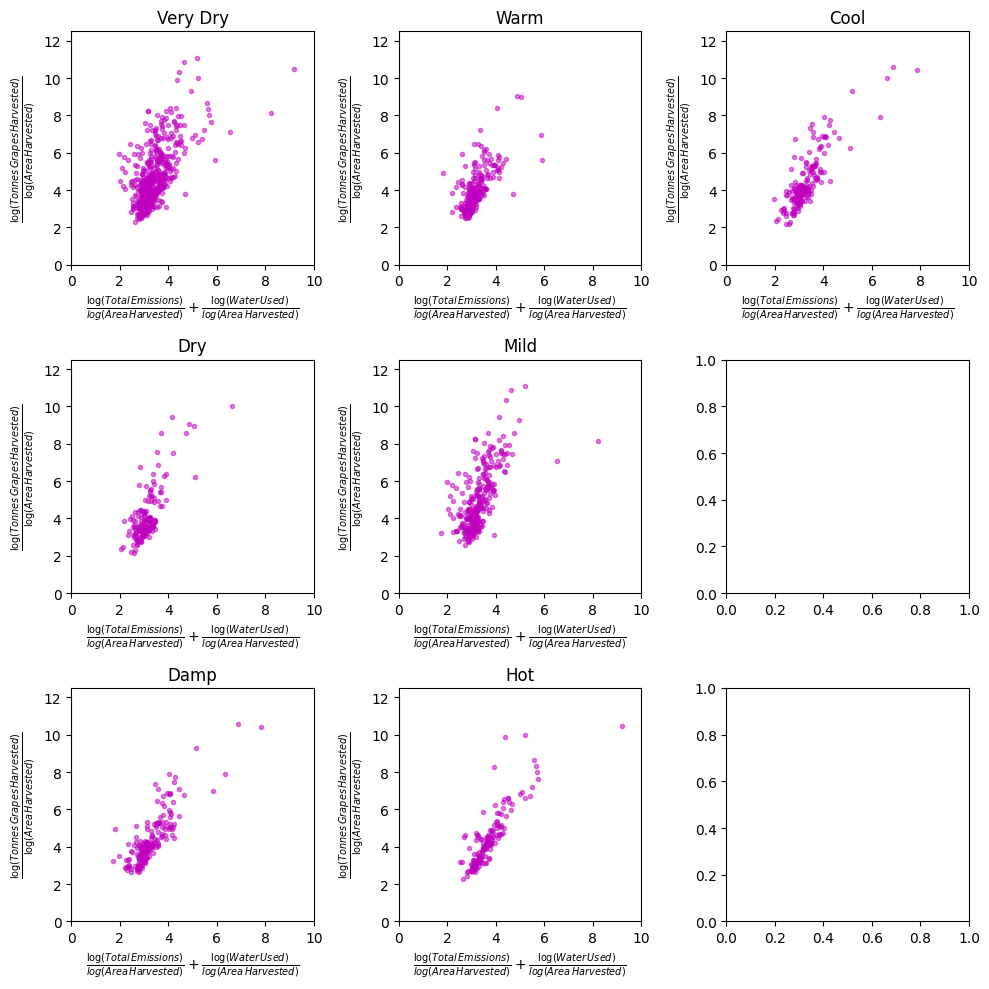

In [67]:
fig, ax = plt.subplots(3, 3,  figsize=(10, 10))

i=0
j=0

for climate in df["rain"].unique():
    if type(climate) is not str:
        continue
    scatter = ax[i][j].scatter(
        df.loc[df["rain"]==climate, "water_and_emmissions"]
        , df.loc[df["rain"]==climate,"yield_avg"]
        , color="m"
        , alpha=0.5
        , label=region
        , marker= "."
    )
    ax[i][j].set_title(climate)
    
    ax[i][j].set_xlabel(r'$\frac{\log(Total\/Emissions)}{log(Area\/Harvested)}+\frac{\log(Water\/Used)}{log(Area\/Harvested)}$')
    ax[i][j].set_ylabel(r'$\frac{\log(Tonnes\/Grapes\/Harvested)}{\log(Area\/Harvested)}$')


    ax[i][j].set_xlim([0,10])
    ax[i][j].set_ylim([0,12.5])
    i += 1
    if i>2:
        j+=1
        i=0

for climate in df["temp"].unique():
    if type(climate) is not str:
        continue
    scatter = ax[i][j].scatter(
        df.loc[df["temp"]==climate, "water_and_emmissions"]
        , df.loc[df["temp"]==climate,"yield_avg"]
        , color="m"
        , alpha=0.5
        , label=region
        , marker= "."
    )
    ax[i][j].set_title(climate)
    
    ax[i][j].set_xlabel(r'$\frac{\log(Total\/Emissions)}{log(Area\/Harvested)}+\frac{\log(Water\/Used)}{log(Area\/Harvested)}$')
    ax[i][j].set_ylabel(r'$\frac{\log(Tonnes\/Grapes\/Harvested)}{\log(Area\/Harvested)}$')


    ax[i][j].set_xlim([0,10])
    ax[i][j].set_ylim([0,12.5])
    i += 1
    if i>2:
        j+=1
        i=0

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

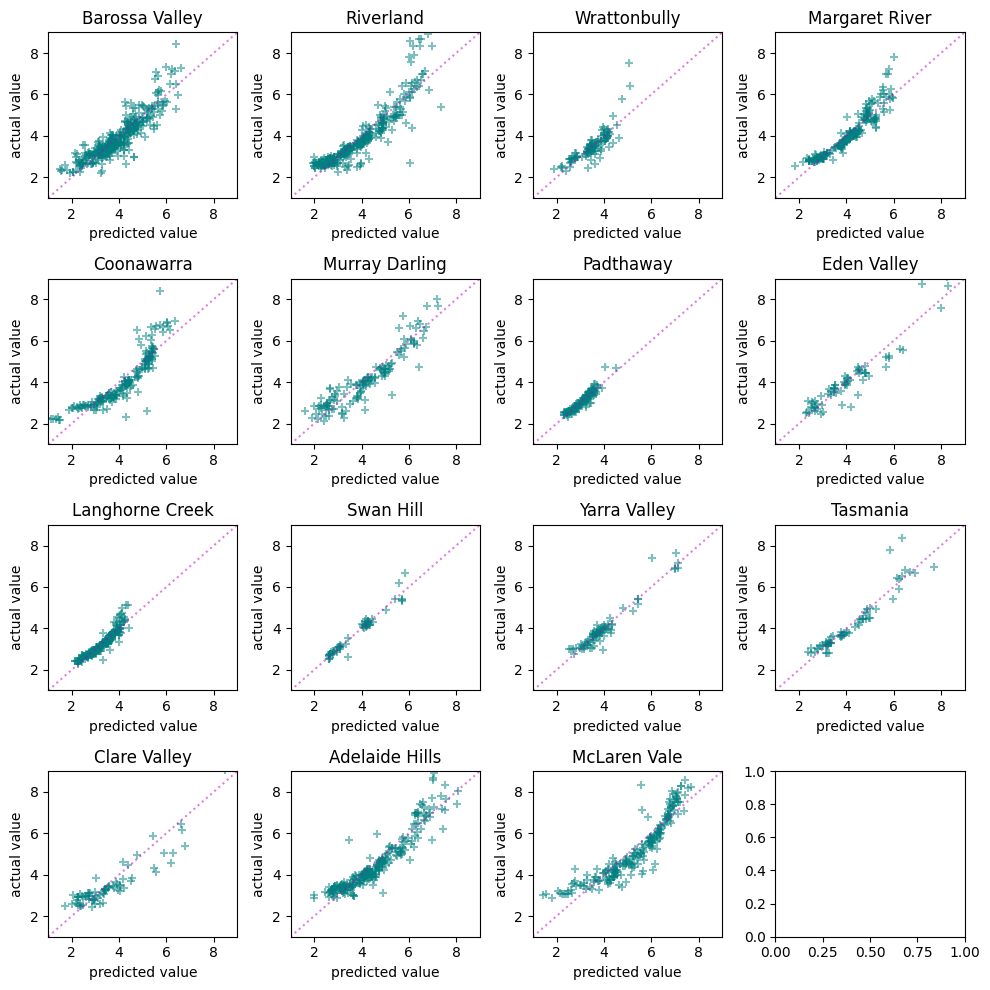

In [170]:
fig, ax = plt.subplots(4, 4,  figsize=(10, 10))

i=0
j=0

for region in region_models.keys():
    if type(region) is not str:
        continue
    
    plot = ax[i][j].plot([1,9], [1,9], color='m', linestyle='dotted', alpha=0.5)
    scatter = ax[i][j].scatter(
        region_models[region][2]
        , region_models[region][17]
        , color="teal"
        , alpha=0.5
        , label=climate
        , marker= "+"
    )
    ax[i][j].set_title(region)
    
    ax[i][j].set_xlabel("predicted value")
    ax[i][j].set_ylabel('actual value')

    ax[i][j].set_xlim([1,9])
    ax[i][j].set_ylim([1,9])
    i += 1
    if i>3:
        j+=1
        i=0


#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

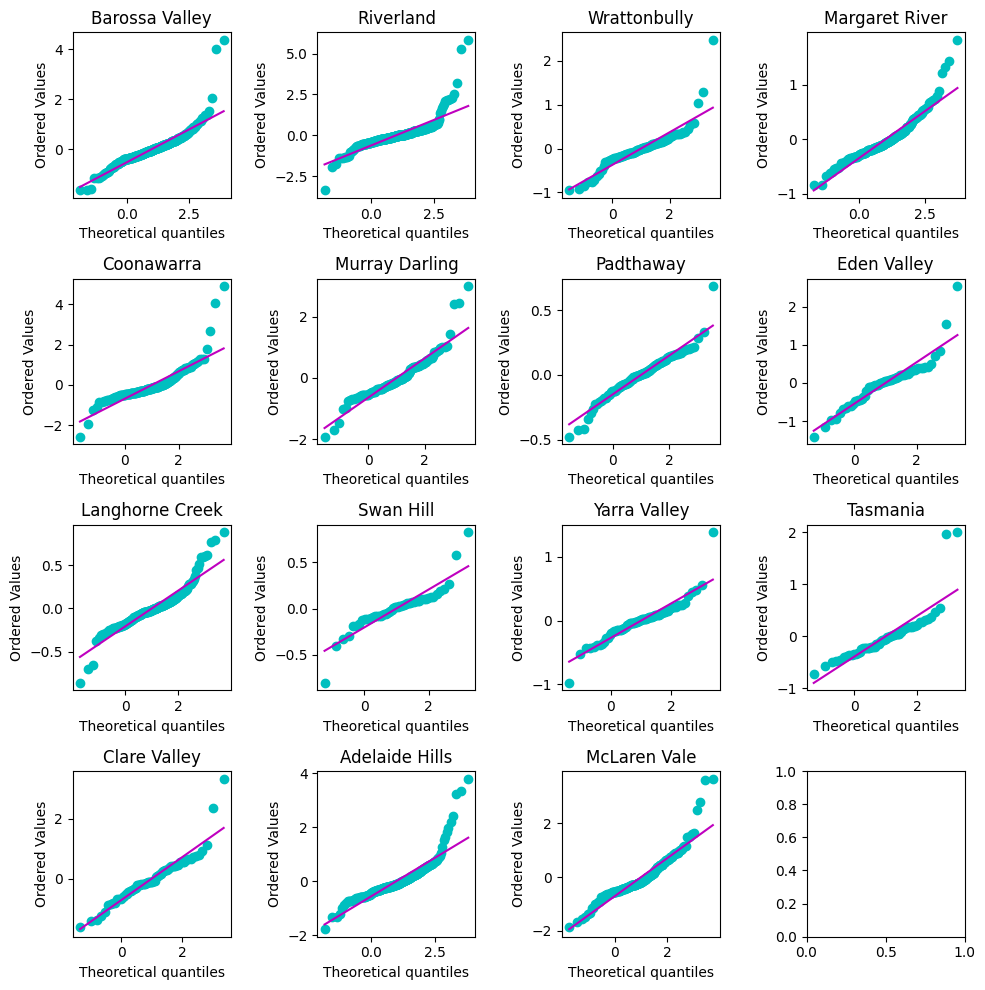

In [169]:
fig, ax = plt.subplots(4, 4,  figsize=(10, 10))

i=0
j=0

for region in region_models.keys():
    if type(region) is not str:
        continue
    stats.probplot(
    region_models[region][1]
    , dist='norm'
    , sparams=(1)
    , plot=ax[i][j]
    )
    ax[i][j].set_title(region)

    ax[i][j].get_lines()[0].set_color("c")
    ax[i][j].get_lines()[1].set_color("m")
    i += 1
    if i>3:
        j+=1
        i=0


#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

(array([   2.,   13.,  143., 1873.,  377.,   37.,   14.,    7.,    4.,
           2.]),
 array([-3.38272069, -2.46091228, -1.53910386, -0.61729545,  0.30451297,
         1.22632139,  2.1481298 ,  3.06993822,  3.99174664,  4.91355505,
         5.83536347]),
 <BarContainer object of 10 artists>)

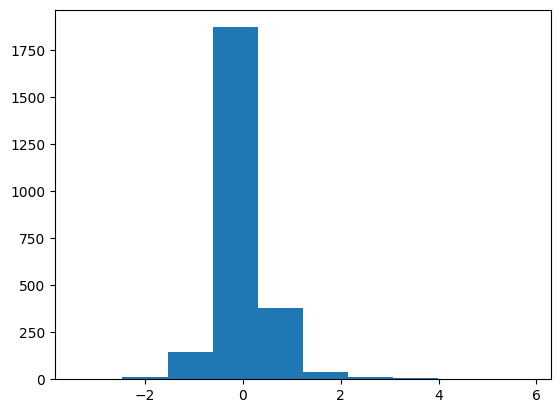

In [160]:
plt.hist(residuals)

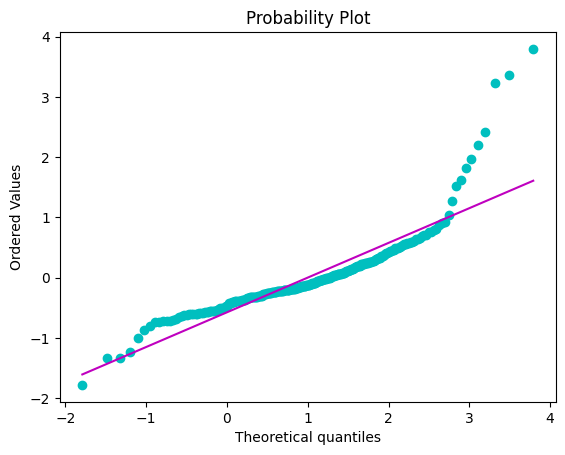

In [163]:
residuals = []
for region in region_models.keys():
    residuals = residuals + list(region_models[region][1])
fig, ax = plt.subplots()

stats.probplot(
    region_models["Adelaide Hills"][1]
    , dist='norm'
    , sparams=(1)
    , plot=ax
)
ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

